In [42]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import operator
import math
#import scipy as scp

# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data

oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data


def data_read_basti_isochrone(f):
    missed_line_inds = []
    temp_data = []
    check = 0
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        # match_header: only true if FIRST character of line is '#'
        match_header = re.match('#',line)
        if match_header or (line.strip()==''):
            missed_line_inds.append(check)
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)
    print 'BaSTI isochrone dataset: ',out_all_data.shape
    return out_all_data


# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column ',col_numb,' values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals

   
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# check Casagrande dictionary - is it just the same as before? Shouldn't be!
def casa_check(A_X_dict,casa_A_X_dict,casa_Teff):
    diff_dict = {}
    offset_arr = []
    temp_arr = []
    combined_set = set(A_X_dict).intersection(set(casa_A_X_dict))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        A_arr_kv = A_X_dict[key_val]
        casa_arr_kv = casa_A_X_dict[key_val]
        for m in range(len(A_arr_kv[:,0])):
            for n in range(len(casa_arr_kv[:,0])):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                if ((casa_arr_kv[n,0] == A_arr_kv[m,0] and casa_arr_kv[n,1] == A_arr_kv[m,1])):
                    offset_arr.append(casa_arr_kv[n,0])
                    offset_arr.append(casa_arr_kv[n,1])
                    for j in range(2,5):
                        offset_arr.append(casa_arr_kv[n,j] - A_arr_kv[m,j])
                    temp_arr.append(offset_arr)
        diff_dict[key_val] = np.array(temp_arr)
    return diff_dict
    
# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        for j in range(len(func_coeffs)):
            # use if statement to avoid repeating terms in symmetrical covariance matrix
            # should result in increasing number of entries for increasing row number
            if (j <= i):
                y = abs(covar_matrix[i][j]/(func_coeffs[i]*func_coeffs[j]))
                f.write(str(y) + '\t')
                yterm_count += 1
                sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# linear function
def linear_func(xdata,a,b):
    y = (a*xdata) + b
    return y

# quadratic function
def quad_func(xdata,a,b,c):
    y = a*(xdata**2) + (b*xdata) + c
    return y

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y

# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# Teff & logg quadratic-like function
# Need y = 0 at Teff cut-off value -> put (Tcut-Tdata) at front
def Teff_logg_product_func(Tdata,Tcut,gdata,ind,a,b,c): #,d
    y = ((Tcut-Tdata)**ind)*(a*(5.0-gdata)**b) + c #*(5.0-gdata)**(b-1)) + d
    return y

#polyfit_coeffs,polyfit_cov = (Tdata-Tcut),Aratio_data,deg

# try to get compensatory functions
# To avoid non-convergence
def Teff_logg_polynomial(Tdata,Tcut,gdata,a,b,c=0.0,d=2):
    # note: want b (power) to be integer!
    y = ((a*(Tcut-Tdata)**d + b*(Tcut-Tdata)**(d-1))*(5.0-gdata)) + c
    return y

# Teff, metallicity & logg quadratic-like function
def Teff_logg_metal_product_func(Tdata,gdata,metal_val,a,b,c=0.0,d=2):
    # assuming Zsolar = 0.0172
    y = ((a*(Tcut-Tdata)**d + b*(Tcut-Tdata)**(d-1))*(5.0-gdata)) + c
    #y = a*(Tdata*gdata) + b*(gdata**2) + c + d*((0.0172 - metal_val)*Tdata)
    return y

# Full addition of exponential function to power-law
def full_pow_plus_exp_func(xdata,a,b,c,d,e):
    y = (d*(xdata**e)) + (a*(np.exp(b*xdata))) + c
    return y

"""
maybe use underdamped oscillation as solution? With log(g), Z related to the value of the damping ratio, G?
For underdamped systems, 0 < G < 1
Approach: change in Ax/Av, call x, has solution x = C*exp(st)
where s = -w_n * (G +/- i*sqrt(1 - G^2))
NumPy: 'j' is the character used for imaginary numbers
"""
def damped_oscillator_gZ(input_params,Tcut,a,b,c,d,k):
    # exponential damping coefficient, function of zeta, the damping ratio
    # need zeta = zeta(g,Z)
    # Free parameters are: a,b,c,d,k
    if type(input_params) is tuple:
        Tdata,gdata,zdata = input_params # if 'input_params' is a tuple
    elif type(input_params) is numpy.ndarray:
        Tdata,gdata,zdata = input_params.T # if 'input_params' is an array
    
    zeta = a*(5.0-gdata) + b*zdata + c
    if (abs(zeta) <= 1.0):
        s = -d*( zeta - 1.0j*np.sqrt(1 - (zeta**2)) )
    else:
        # PROBLEM: if zeta2**2 > 1, gives nan rather than evaluating two imaginary numbers!
        s = -d*( zeta - np.sqrt((zeta**2) - 1) )
    
    # 'Tdata' called below! - this should remove the need to use it anywhere in 'zeta'
    
    #R = a*(Tcut - Tdata)
    new_var = (k*(Tcut - Tdata))*np.exp(s*(Tcut-Tdata))
    return new_var

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects


# need to combine some effects of Teff, log(g)
# use Teff-keyed dictionaries as the dataset
def from_keys_get_numerical_data(input_dict):
    key_vals_list = []
    for key in sorted(input_dict.iterkeys()):
        float_key = float(key)
        key_vals_list.append(float_key)
    
    key_vals_arr = np.array(key_vals_list)
    print 'Array of key values: ', key_vals_arr.shape
    return key_vals_arr

# functions to reproduce Casagrande & Vandenberg (in prep.) behaviour
def casa_T4_range(Teff_vals,min_val,max_val):
    T4_list = []
    Teff_list = []
    #if (min_val in Teff_vals and max_val in Teff_vals):
    for i in Teff_vals:
        if (min_val <= i <= max_val):
            Teff_list.append(i)
            # T4 defined as Teff*(10^-4)
            T4_list.append(i*(1.0e-4))
    #else:
    T4r = np.array(T4_list)
    Teffr = np.array(Teff_list)
    return Teffr,T4r

# extinction coefficient, R_X = A(X)/E(B-V) ALWAYS!!!
# -> need to find E(B-V) values, then use to compare

# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

# define the actual load-up of the functions to be fitted separately
def functions_loadup(function,x_coords_fit,y_coords_fit,bounds_list,coeffs_list,cov_arr_list):
    # functions_list, bounds_list MUST MATCH in their orders!! (functions and coefficient bounds, respectively)
    #for a in functions_list: # iterate between function types
    function_coeffs,covarr = curve_fit(function,x_coords_fit,y_coords_fit, p0=None, sigma=None,bounds=bounds_list)
    coeffs_list.append(function_coeffs)
    cov_arr_list.append(covarr)
    #return coeffs_list,cov_arr_list

# curve fitting function
def filter_curve_fit(dict_chosen,key,filter_str):
    A_X_chosen = dict_chosen[key]
    if (key == '5.0'):
        # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
        # store using the following lists:
        exp_fit_A_logg5_list = []
        covarr_A_logg5_ef_list = []
        pow_fit_A_logg5_list = []
        covarr_A_logg5_pow_list = []
        #spp_exp_fit_A_logg5_list = []
        #covarr_A_logg5_spp_list = []
        plpe_fit_A_logg5_list = []
        covarr_A_logg5_plpe_list = []
        
        for i in range(2,len(A_X_chosen[0,:])):
            functions_loadup(exp_func,A_X_chosen[:,0],A_X_chosen[:,i],exp_bounds[i-2],exp_fit_A_logg5_list,covarr_A_logg5_ef_list)
            functions_loadup(single_poly,A_X_chosen[:,0],A_X_chosen[:,i],pow_bounds[i-2],pow_fit_A_logg5_list,covarr_A_logg5_pow_list)
            functions_loadup(full_pow_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i],plpe_bounds[i-2],plpe_fit_A_logg5_list,covarr_A_logg5_plpe_list)
            
            #exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
            #pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
            #spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])

            exp_fit_A_logg5 = exp_fit_A_logg5_list[i-2]
            covarr_A_logg5_ef = covarr_A_logg5_ef_list[i-2]
            pow_fit_A_logg5 = pow_fit_A_logg5_list[i-2]
            covarr_A_logg5_pow = covarr_A_logg5_pow_list[i-2]
            plpe_fit_A_logg5 = plpe_fit_A_logg5_list[i-2]
            covarr_A_logg5_plpe = covarr_A_logg5_plpe_list[i-2]
            
            # print fitting results
            print 'Calculating coefficients & covariance matrices for ' + filter_str[i-2] + ' filter'
            
            print 'Exponential fit coefficients: '
            print exp_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_ef

            print 'Teff^(n) fit coefficients: '
            print pow_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_pow

            print 'Teff^(n) + exponential fit coefficients: '
            print plpe_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_plpe
            
            print 2*'\n'
            
        print 'Number of fit operations = ', len(exp_fit_A_logg5_list)
        print 'List object type: ', type(exp_fit_A_logg5_list)
        # combine lists to store for log(g) != 5.0 function runs
        combined_list = [exp_fit_A_logg5_list,covarr_A_logg5_ef_list,pow_fit_A_logg5_list,covarr_A_logg5_pow_list,plpe_fit_A_logg5_list,covarr_A_logg5_plpe_list]
        #print combined_list
    print '\n         FITTING OPERATION COMPLETE \n'
    return combined_list

        
# plot & write results
def filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,A_X_z1_gfix,A_X_zh_gfix,combined_list,key,metal,extras,filter_str,folder,graph_fold,casa_opt,multiplot_file,zoom_min=None,zoom_max=None):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
        casa_chosen = casa_arr_zs
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
        casa_chosen = casa_arr_z2
    elif (metal == 'sol_10'):
        A_X_chosen = A_X_z1_gfix[key]
        casa_chosen = casa_arr_z1
    elif (metal == 'solx3'):
        A_X_chosen = A_X_zh_gfix[key]
        casa_chosen = casa_arr_zh
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    
    # Hubble data: easier to use subplots -> add option
    if (multiplot_file == 'y'):
        plot_dir_str_i = None
        data_dir_str_i = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_i = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers.txt'
        if (key == '5.0'):
            with open (data_dir_str_i,'w') as f:
                f.close()
        # Iteration for changes BETWEEN filters !!!
        for i in range(2,len(A_X_chosen[0,:])):
            # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
            # use lists filled in before (for log(g) = 5.0) to provide fit-curve data
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            plpe_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_plpe = (combined_list[5])[i-2]
            
            # check that fitting numbers are retained
            if (i == 2 and key != '5.0'):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print plpe_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_plpe
                
                print 2*'\n'
            
            
            if (key == '5.0'):
                avg_dict = {}
                with open (data_dir_str_i,'a') as f:
                    print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                    # write results of comparison of averages
                    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                    for j in sorted_avg:
                        f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                    f.close()
                    #_0.02
                
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
            # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
            axs[i-2].plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='--',label='Data lower accuracy limit (data - 0.01)')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.02),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.02)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.02),'k',linestyle='-.',label='Data upper accuracy limit (data + 0.02)')
            axs[i-2].plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
            axs[i-2].plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
            axs[i-2].plot(A_X_chosen[:,0],full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5),'r',label=fit_types[2])
            if (zoom_min is not None and zoom_max is not None):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            axs[i-2].set_title(title_str, y=1.02)
            
            
        plot_dir_str_i = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot.pdf'
        
            
            
        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        plt.show()
        fig.savefig(plot_dir_str_i, bbox_inches='tight')

    else:
        # Iteration for changes BETWEEN filters !!!
        # i.e., should produce 3 versions of each output each time the function is called
        for i in range(2,len(A_X_chosen[0,:])):
            # empty directory string - avoid potential concatonation
            plot_dir_str_i = None
            data_dir_str_i = None
            # curve-fitting commands
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            plpe_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_plpe = (combined_list[5])[i-2]

            # check that fitting numbers are retained
            if (i == 2):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print plpe_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_plpe
                
                print 2*'\n'

            # Construct directories, files to save plots,data - i.e. construct strings
            # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
            if (casa_opt == 'y' and i == 2):
                folder += '_casa'
                graph_fold += '_casa'

            plot_dir_str_i = folder + '/' + graph_fold + '/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'
            data_dir_str_i = folder + '/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers'
            # separate Casagrande data
            if (casa_opt == 'y'): # and i == 2
                plot_dir_str_i += '_casa'
                data_dir_str_i += '_casa'
            plot_dir_str_i += '.pdf'
            data_dir_str_i += '.txt'
            
            # plot commands
            fig, ax = plt.subplots()
            ax.set_xlabel(var_names[0])
            ax.set_ylabel(var_names[i])
            if (casa_opt == 'y'):
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='-',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(casa_chosen[:,0],casa_chosen[:,i],'b',marker='x',linestyle='-',label='Casagrande data')
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            else:
                # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
                # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
                ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
                ax.plot(A_X_chosen[:,0],full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5),'r',label=fit_types[2])
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.show()
            fig.savefig(plot_dir_str_i, bbox_inches='tight')

            # data file write commands
            
            avg_dict = {}
            with open (data_dir_str_i,'w') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model'
                general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   \n')
                for j in sorted_avg:
                    f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                f.close()
                
            #with open (folder + '/coeffs_summary_cas.txt','a') as sf:
                #sf.write('Fit coefficients summary')
                #sf.write('log(g) = ' + key + ', Z = ' + metal + ', ' + filter_str[i-2] + ' filter ' + 3*'\t' + str(pow_fit_A_logg5) + '\n')
            #sf.close()
            print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n    Writing complete for log(g) = ' + key + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

def comb_hub_gaia_dict(Ahub,Agaia):
    comb_dict = {}
    for key in sorted(Ahub.iterkeys()):
        #print key
        hub_arr = Ahub[key]
        #print hub_arr_zs.shape
        #print len(hub_arr_zs[:,0])
        gaia_arr = Agaia[key]
        comb_arr = np.zeros((len(hub_arr[:,0]),(len(hub_arr[0,:]) + 3)))
        comb_arr[:,:-3] = np.copy(hub_arr)
        comb_arr[:,-3:] = np.copy(gaia_arr[:,2:5])
        #comb_arr_zs = np.append(hub_arr_zs,gaia_arr_zs[:,2:5])
        comb_dict[key] = comb_arr
    return comb_dict

# extract coefficients into a summary file
def make_coeffs_summary(directory,infile,outfile,filter_names,logg_val,metal,writing_type):
    locin = directory + infile
    locout = directory + outfile

    with open(locin,'r') as inputf, open(locout,writing_type) as outputf:
        n = 0
        copy_bool = False
        #outputf.write('Coefficients for Teff power law: \n\n')
        #if (n <= (len(filter_names)-1)):
        #copy_bool = False
        for line in inputf:
            #if ('Fitting results for' in line.strip()): == '    Covariance matrix:'
                #outputf.write(line)
            if (line.strip() == 'Function type:  Power law of Teff, fitted'):
                copy_bool = True
                n += 1
            elif ('Covariance' in line.strip()):
                copy_bool = False
            elif copy_bool:
                if ('Fit coefficients (in order of functions arguments)' in line.strip()):
                    continue
                else:
                    print n
                    outputf.write(filter_names[n-1] + ' filter, with  log(g) = ' + logg_val + ' and Z = Z' + metal + ': \t\t' + line)
                    

        outputf.write('#\n#\n')
        inputf.close()
        outputf.close()

# Cutoff - tailflick evasion for fixed-log(g) dictionaries
def Teff_cutoff_fix_logg_dict(old_dict,criterion):
    new_dict = {}
    x = 0
    print 'Cutoff - tailflick evasion for fixed-log(g) dictionaries'
    for key in sorted(old_dict.iterkeys()):
        temp_arr_list = []
        #print new_dict[key].shape
        for i in range(len(old_dict[key][:,0])):
            if (old_dict[key][i,0] >= criterion):
                temp_arr_list.append(old_dict[key][i,:])
                #print 'Teff value too low: ',new_dict[key][i,0]
            elif(x == 0 and old_dict[key][i,0] < criterion):
                print old_dict[key][i,0]
        new_dict[key] = np.array(temp_arr_list)
        x += 1
    print x
    return new_dict

def casa_Rfil_eq(t4_range,metal,a0,a1,a2,a3):
    if (metal == 'solar'):
        FeH = 0
    elif (metal == 'sol_100'):
        FeH = -2
    elif (metal == 'sol_10'):
        FeH = -1
    elif (metal == 'solx3'):
        FeH = 0.5
    Rfil = a0 + (t4_range*(a1 + (a2*t4_range))) + (a3*FeH)
    return (Rfil/3.1) # = Afil/Av

def casa_build(teff_range,Rfil_G,Rfil_Gbp,Rfil_Grp):
    casa_arr = np.zeros((teff_range.size,5))
    casa_arr[:,0] = teff_range
    casa_arr[:,2] = Rfil_G
    casa_arr[:,3] = Rfil_Gbp
    casa_arr[:,4] = Rfil_Grp
    return casa_arr


# High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries
def Teff_cutoff_fix_Teff_dict(old_dict,lower_lim,upper_lim=50000.0):
    new_dict = {}
    #print 'High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries'
    
    for key in sorted(old_dict.iterkeys()):
        float_key_val = float(key)
        #print float_key_val
        if (lower_lim <= float_key_val <= upper_lim):
            new_dict[key] = old_dict[key]
            #print float_key_val
            
    print 'Dictionary size (number of Teff values, full dictionary then cutoff-limited): '
    print len(old_dict),len(new_dict)
    return new_dict


# function to generate difference dictionaries, with arrays of varying log(g) for fitting (Teff-value keys)
def diff_from_ref_Teff_key(input_dict,Teff_max_lim=None):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        if (Teff_max_lim is not None and float(key) <= Teff_max_lim):
            holder_arr = (input_dict[key])
            i_list = []
            for i in range(len(holder_arr[:,0])): # iterate over rows
                j_list = []
                for j in range(len(holder_arr[0,:])): # iterate over columns in row
                    if (j==0 or j==1):
                        j_val = holder_arr[i,j]
                    else:
                        j_val = (holder_arr[i,j] - holder_arr[-1,j])
                    j_list.append(j_val)
                i_list.append(j_list)
            out_dict[key] = np.array(i_list)
            #print 'Teff cut check for key = '+key,out_dict[key].shape
            # current layout: only difference values for Teff < Teff_max_lim
    return out_dict

# function to generate difference dictionaries, with arrays of varying Teff for fitting (log(g) values as keys, same as final plot format)
def diff_from_ref_logg_key(input_dict,R1_sim_dict,Teff_max_lim=None,ref_sim_yn='n'):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = input_dict[key]
        # ref_sim_yn indicates whether the reference dictionary to be used is a dictionary of data
        # generated using the R1 coefficients or the dictionary's own data using log(g)=5.0
        if (ref_sim_yn == 'n'):
            ref_arr = input_dict['5.0']
        else:
            ref_arr = R1_sim_dict[key]
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            if (Teff_max_lim is not None and holder_arr[i,0] <= Teff_max_lim):
                j_list = []
                for j in range(len(holder_arr[0,:])): # iterate over columns in row
                    if (j==0 or j==1):
                        j_val = holder_arr[i,j]
                    else:
                        j_val = (holder_arr[i,j] - ref_arr[i,j])
                    j_list.append(j_val)
                i_list.append(j_list)
        if (i_list != []):
            out_dict[key] = np.array(i_list)
            #print 'Teff cut check for key = '+key,out_dict[key].shape
    return out_dict

# for Teff-only functions, create dictionary to store data from results of round 1 coefficient fitting
def make_sim_Teff_R1_array(input_dict,best_fits_filterwise):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = np.copy(input_dict[key])
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            j_list = []
            for j in range(len(holder_arr[0,:])): # iterate over columns in row
                if (j==0 or j==1):
                    j_val = holder_arr[i,j]
                else:
                    if (best_fits_filterwise[j-2] == 'exp'):
                        j_val = exp_func(holder_arr[i,0], *exp_Teff_coef_4500K_logg_5[j-2])
                    elif (best_fits_filterwise[j-2] == 'plpe'):
                        j_val = full_pow_plus_exp_func(holder_arr[i,0], *plpe_Teff_coef_4500K_logg_5[j-2])
                    else: # treat 'pow' as the standard
                        j_val = single_poly(holder_arr[i,0], *pow_Teff_coef_4500K_logg_5[j-2])
                j_list.append(j_val)
            i_list.append(j_list)
        out_dict[key] = np.array(i_list)
    return out_dict

# function to calculate logg-only coefficients (quadratic in log(g))
def logg_coeffs_calc(fit_out,input_diff_dict,fitting_func,fit_func_bounds,filter_names):
    # Initialise output dictionaries (as empty, naturally)
    coeffs_dict_key_fix_Teff = {}
    cov_dict_key_fix_Teff = {}
    with open(fit_out,'w') as f:
        f.close()
      
    # one iterator value per Teff-value 'key'
    x = 0
    
    logg_coeffs_at_1_Teff = []
    logg_cov_at_1_Teff = []
    for key in reversed(sorted(input_diff_dict.iterkeys())):
        x += 1
        
        # should give 16 iterations in this loop (going between filters)
        # Do thi ONLY for the first Teff value (should be the largest Teff value)
        if (x == 1):
            for i in range(2,len((input_diff_dict[key])[0,:])):
                """j_stuff = []
                for j in range(len((input_dict[key])[:,i])):
                    jdiff = abs((input_dict[key])[j,i] - (input_dict[key])[-1,i])
                    j_stuff.append(jdiff)
                if (max(j_stuff)>=0.01):"""

                # store outputs of curve_fit (one set/matrix per key, i.e. Teff value)
                # N.B.: f((input_dict[key])[:,1], *coeffs) - (input_dict[key])[:,i] minimised in curve_fit evaluation

                coeffs,cov_mat = curve_fit(fitting_func,(input_diff_dict[key])[:,1],(input_diff_dict[key])[:,i], p0=None, sigma=None,bounds=fit_func_bounds)
                # append these resultant 1D-NUMPY ARRAYS to lists
                logg_coeffs_at_1_Teff.append(coeffs)
                logg_cov_at_1_Teff.append(cov_mat)

                # file write
                with open(fit_out,'a') as f:
                    f.write('Log(g) coefficient analysis for filter: ' + filter_names[i-2] + '\n')
                    f.write('(function has the form: y = a*(log(g)**2) + (b*log(g)) + c) \n')
                    if (key[0] == '0'):
                        tidy_key = key[1:]
                        f.write('Fixed parameter: Teff = ' + tidy_key + '\n')
                    else:
                        f.write('Fixed parameter: Teff = ' + key + '\n')

                    f.write('Number of points (maximum of 11): ' + str(len(input_diff_dict[key][:,0])) + '\n')
                    f.write('Log(g) quadratic fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n')
                    f.close()
            # end of file write
        # save lists to dictionaries (each list should now cover log(g) variations for all 16 filters for a single Teff value)
        # each list should also be identical!!
        coeffs_dict_key_fix_Teff[key] = logg_coeffs_at_1_Teff
        cov_dict_key_fix_Teff[key] = logg_cov_at_1_Teff
        # Final dictionaries should have a number of keyed entries equal to the total number of Teff values
        # in original data dictionary. Each keyed entry should be a list of 16 1D-numpy arrays of
        # quaadratic coefficients (1 array per filter, with the filters in their original order from NoMachine output data)
        
        # NOTE: can select the Teff-key value to use in final combination using 'combined_effects_grid_sync' function
    return coeffs_dict_key_fix_Teff, cov_dict_key_fix_Teff
                       
"""if (Teff_key[0] == '0'):
                Teff_tidy_key = Teff_key[1:]
            else:
                Teff_tidy_key = Teff_key
        if (j == 0):
            print A_final_pow_combo_i[j],A_pow_Teff_only_i[j],A_logg_diff_i
            if (logg_key == '0.0' and i == 2):
                print 'Testing log(g) calculation output values:'
                print A_logg_diff_i
                print A_final_pow_combo_i - A_pow_Teff_only_i"""

# coefficient calculations for functions using both Teff & log(g) as input
def all_params_combined_coeffs_calc(fit_out,Teff_only_dict,fitting_func,fit_func_bounds,filter_names,start_fit_at=None,Tmod_pow=1.0,model_tmod_yn='n'):#,ref_key
    
    with open(fit_out,'w') as f:
        f.close()
    
    mod_pred_coeffs_dict = {}
    mod_pred_covar_dict = {}
    # temporary storage list for log(g) = 4.5 coefficients, covariances
    coeffs_45 = []
    cov_mat_45 = []
    # reverse order ('5.0', '4.5', etc.)
    
    for key in reversed(sorted(Teff_only_dict.iterkeys())):#reversed
        #print key
        two_var_coeffs_at_1_logg = []
        two_var_covar_at_1_logg = []
        
        # get indices for max,min,middle Teffs
        sigma_corr = np.ones(len((Teff_only_dict[key])[:,0]))
        
        max_Teff_val = max((Teff_only_dict[key])[:,0])
        min_Teff_val = min((Teff_only_dict[key])[:,0])
        middle_index = np.where((Teff_only_dict[key])[:,0] == 6000.0)
        low_fix_index = np.where((Teff_only_dict[key])[:,0] == 5000.0)
        
        middle_Teff_val = ((Teff_only_dict[key])[:,0])[middle_index]
        print 'Temperatures to (maybe) be anchors: ',min_Teff_val,middle_Teff_val,max_Teff_val
        # manipulate curve_fit's 'sigma' parameter to force fitting through the previously-predicted Teff-cutoff point
        sigma_corr[middle_index] = 0.01
        sigma_corr[low_fix_index] = 0.01
        #sigma_corr[np.argmin((Teff_only_dict[key])[:,0])] = 0.001
        if (max_Teff_val <= max((Teff_only_dict[key])[:,0])):
            sigma_corr[np.argmax((Teff_only_dict[key])[:,0])] = 0.001
        if (key == '5.0'):
            for x in range(len((Teff_only_dict['5.0'])[:,0])):
                print 'index line-up: ',sigma_corr[x],((Teff_only_dict['5.0'])[:,0])[x]
        print 'Maximum temperature of Teff_only_dict['+key+']: ',max_Teff_val
        
        # iterate over all 16 filters    
        for i in range(2,len((Teff_only_dict['5.0'])[0,:])):
            if (key == '5.0'):
                # use a new variable to 'fit' the coefficients to zero for log(g) = '5.0'
                zeros_y = np.copy((Teff_only_dict[key])[:,i])
                zeros_y.fill(0.0)
                """ REMEMBER THE FUNCTION'S FORM!
                Teff_logg_product_func(Tdata,Tcut,gdata,a,b,c):
                    y = a*((Tcut-Tdata)*(5-gdata)**b) + c
                    return y"""
                if (model_tmod_yn == 'n'):
                    coeffs,cov_mat = curve_fit(lambda x,*alist: fitting_func(x,max_Teff_val,float(key),Tmod_pow,*alist),((Teff_only_dict[key])[:,0]),zeros_y, p0=[0.]*len(start_fit_at), sigma=None)
                else:
                    #p0list = [0.,0.,0.]
                    coeffs,cov_mat = curve_fit(lambda x,T,*alist: fitting_func(x,max_Teff_val,float(key),T,*alist),((Teff_only_dict[key])[:,0]),zeros_y, p0=[0.]*len(start_fit_at), sigma=None)
            # MODIFY curvefit inputs FOR TWO input variables!!!
            elif (key == '4.5'): # greatest Teff range outside 5.0
                
                print 'Max occurs at the following index: ',np.argmax((Teff_only_dict[key])[:,0])
                #print 'Total length of Teff_only_dict['+key+']: ', len((Teff_only_dict[key])[:,0])#(5.0-float(key))
                if (model_tmod_yn == 'n'):
                    coeffs,cov_mat = curve_fit(lambda x,*alist: fitting_func(x,max_Teff_val,float(key),Tmod_pow,*alist),((Teff_only_dict[key])[:,0]),(Teff_only_dict[key])[:,i], p0=start_fit_at, sigma=sigma_corr,bounds=fit_func_bounds)
                else:
                    coeffs,cov_mat = curve_fit(lambda x,T,*alist: fitting_func(x,max_Teff_val,float(key),T,*alist),((Teff_only_dict[key])[:,0]),(Teff_only_dict[key])[:,i], p0=start_fit_at, sigma=sigma_corr,bounds=fit_func_bounds)
                coeffs_45.append(coeffs)
                cov_mat_45.append(cov_mat)
                print key,comb_filter_str[i-2],'Coefficients :', coeffs
                if (model_tmod_yn == 'n'): 
                    print 'Test output at 8000K: ', fitting_func(max_Teff_val,max_Teff_val,float(key),Tmod_pow,*coeffs)
                else:
                    print 'Test output at 8000K: ', fitting_func(max_Teff_val,max_Teff_val,float(key),*coeffs)
                #print 'Output types (should be lists): ',type(coeffs_45),type(cov_mat_45)
                #print 'lists contain: ',type(coeffs_45[0]),type(cov_mat_45[0])
            
                # file write - only for the log(g) value being used for fitting
                with open(fit_out,'a') as f:
                    f.write('Teff & log(g) function coefficient analysis for filter: ' + filter_names[i-2] + '\n')
                    f.write('(function has the form: y = a*(Teff*log(g)) + b*log(g) + c) \n\n')

                    f.write('Fixed parameter: log(g) = ' + key + '\n')

                    f.write('Number of points (maximum of 72): ' + str(len(Teff_only_dict[key][:,0])) + '\n\n')
                    f.write('Two-variable function fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n\n')
                    f.close()
                    
            else:
                #print 'dfgkjfddfodfkg',len((Teff_only_dict[key])[:,0]),len((Teff_only_dict[key])[:,5])
                """
                size_diff = abs(len(sigma_corr) - len((Teff_only_dict[key])[:,0]))
                sigma_corr2 = sigma_corr
                if (max_Teff_val > max((Teff_only_dict[key])[:,0])):
                    print 'no emphasis for '+key
                    sigma_corr2 = None"""
                #coeffs,cov_mat = curve_fit(lambda x,a,b,c: fitting_func(x,max_Teff_val,float(key),Tmod_pow,a,b,c),((Teff_only_dict[key])[:,0]),(Teff_only_dict[key])[:,i], p0=start_fit_at, sigma=sigma_corr,bounds=fit_func_bounds)
                #print key,comb_filter_str[i-2],'Coefficients :',coeffs
                coeffs = coeffs_45[i-2]
                cov_mat = cov_mat_45[i-2]
                
            two_var_coeffs_at_1_logg.append(coeffs)
            two_var_covar_at_1_logg.append(cov_mat)
            # end of file write
        # adding a list of 16 arrays to each dictionary
        mod_pred_coeffs_dict[key] = two_var_coeffs_at_1_logg
        mod_pred_covar_dict[key] = two_var_covar_at_1_logg
            
    return mod_pred_coeffs_dict,mod_pred_covar_dict

# add first-round Teff variations and second round log(g),Teff adjustments together using iterations
def combined_effects_grid_sync(logg_fixed_R1_dict,coeffs_dict_in,Teff_key,best_fits_filterwise,product_func,Tmod_pow,Teff_max=None,model_tmod_yn='n'):
    # check if coefficients dictionary has keys containing log(g) values (combined Teff-log(g) functions)
    # or keys containing Teff values (log(g)-only functions)
    # Do this by matching key strings - SHOULD ONLY MATCH IF BOTH DICTIONARIES HAVE THE SAME KEY VARIABLE!
    logg_val_count = 0
    for logg_val_str in logg_fixed_R1_dict:
        for key_val_str in coeffs_dict_in:
            match_logg_val_keys = re.match(key_val_str,logg_val_str)
            if match_logg_val_keys is not None:
                logg_val_count += 1
    print 'Teff-matching results between Teff & log(g) dictionaries: ',logg_val_count
    
    # if there are no matches, we are using the log(g) coefficients dictionary
    # - only 1 per filter (each dictionary contains only 1 item)!            
    if (logg_val_count == 0):
        # pick ONE Teff value for 'independent' log(g) form from dictionary - fix later!
        # Update: all log(g)-only coefficient dictionary entries should be identical!!
        logg_coeffs_stored = coeffs_dict_in[Teff_key]
    
    # plot-format data dictionary (fixed-log(g)) - iterate between output files
    combined_prediction_dict = {}
    Teff_prediction_R1_dict = {}
    
    if Teff_max is not None:
        logg_fixed_R1_dict_trunc = trunc_for_low_Teff_fitting(logg_fixed_R1_dict,Teff_max)
    else:
        logg_fixed_R1_dict_trunc = logg_fixed_R1_dict
    
    for logg_key in logg_fixed_R1_dict:
        # data array for given log(g) key-value
        logg_fixed_arr = logg_fixed_R1_dict[logg_key]
        logg_fixed_arr_trunc = logg_fixed_R1_dict_trunc[logg_key]
        max_Teff_val = max(logg_fixed_arr_trunc[:,0])
        # Initialise outputs by copying above data array
        combo_predict_arr = np.copy(logg_fixed_arr)
        Teff_predict_arr = np.copy(logg_fixed_arr)
        
        # Account for the difference between the two approaches to the log(g) effect, key-wise
        # First case: log(g) only
        if (logg_val_count == 0):
            # iterate over filters - within each output file
            for i in range(2,len(logg_fixed_arr[0,:])):
                # CURRENTLY, A_func_Teff_only_i is a 1D array predicting the Teff-only Ax/Av values
                # from the (1D) Teff input array, using PREVIOUSLY-CALCULATED coefficients
                if (best_fits_filterwise[i-2] == 'exp'):
                    A_func_Teff_only_i = exp_func(logg_fixed_arr[:,0], *exp_Teff_coef_4500K_logg_5[i-2])
                elif (best_fits_filterwise[i-2] == 'plpe'):
                    A_func_Teff_only_i = full_pow_plus_exp_func(logg_fixed_arr[:,0], *plpe_Teff_coef_4500K_logg_5[i-2])
                else: # treat 'pow' as the standard
                    A_func_Teff_only_i = single_poly(logg_fixed_arr[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
                # Initialise final combined Ax/Av prediction using Teff-only prediction
                A_final_func_combo_i = np.copy(A_func_Teff_only_i)

                # process log(g) value (plot-format's key) using log(g) coefficients at selected Teff_key
                # if log(g) = 5.0, NO CHANGE from Teff-only fit!!!
                if (logg_key == '5.0'):
                    A_logg_diff_i = 0.0
                else:
                    A_logg_diff_i = quad_func(float(logg_key), *logg_coeffs_stored[i-2])
                # final combination calculated for each log(g) value, filter
                for j in range(len(A_func_Teff_only_i)):
                    A_final_func_combo_i[j] = A_func_Teff_only_i[j] + A_logg_diff_i

                Teff_predict_arr[:,i] = A_func_Teff_only_i
                combo_predict_arr[:,i] = A_final_func_combo_i
                
        # Second case: log(g)-Teff product
        else:
            two_var_mod_coeffs_stored = coeffs_dict_in[logg_key]
            # iterate over filters - within each output file
            for i in range(2,len(logg_fixed_arr[0,:])):
                # CURRENTLY, A_func_Teff_only_i is a 1D array predicting the Teff-only Ax/Av values
                # from the (1D) Teff input array, using PREVIOUSLY-CALCULATED coefficients
                if (best_fits_filterwise[i-2] == 'exp'):
                    A_func_Teff_only_i = exp_func(logg_fixed_arr[:,0], *exp_Teff_coef_4500K_logg_5[i-2])
                elif (best_fits_filterwise[i-2] == 'plpe'):
                    A_func_Teff_only_i = full_pow_plus_exp_func(logg_fixed_arr[:,0], *plpe_Teff_coef_4500K_logg_5[i-2])
                else: # treat 'pow' as the standard
                    A_func_Teff_only_i = single_poly(logg_fixed_arr[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
                # Initialise final combined Ax/Av prediction using Teff-only prediction
                A_final_func_combo_i = np.copy(A_func_Teff_only_i)

                # process log(g) value (plot-format's key) using log(g) coefficients at selected Teff_key
                # if log(g) = 5.0, NO CHANGE from Teff-only fit!!!
                if (logg_key == '5.0'):
                    # setting all coefficients to zero gives array of correct dimensions, but full of zeros
                    A_logg_diff_i = product_func(logg_fixed_arr_trunc[:,0], Teff_max, 0.0, 0.0, 0.0, 0.0, 0.0)
                else:
                    # sfdfj
                    if (model_tmod_yn == 'n'):
                        A_logg_diff_i = product_func(logg_fixed_arr_trunc[:,0], Teff_max, float(logg_key), Tmod_pow, *two_var_mod_coeffs_stored[i-2])
                    else:
                        A_logg_diff_i = product_func(logg_fixed_arr_trunc[:,0], Teff_max, float(logg_key), *two_var_mod_coeffs_stored[i-2])
                # final combination calculated for each log(g) value, filter
                #for j in range(len(A_func_Teff_only_i)):
                #print 'Checking lengths of Teff arrays: ',len(logg_fixed_arr_trunc[:,0]), len(logg_fixed_arr[:,0])
                if (len(logg_fixed_arr_trunc[:,0]) < len(logg_fixed_arr[:,0])):
                    #print 'Testing truncation adjustments:'
                    for j in range(len(logg_fixed_arr_trunc[:,0])):
                        A_final_func_combo_i[j] = A_func_Teff_only_i[j] + A_logg_diff_i[j]
                        #print A_final_func_combo_i[j], A_func_Teff_only_i[j], A_logg_diff_i[j]
                        
                else:
                    A_final_func_combo_i = A_func_Teff_only_i + A_logg_diff_i

                Teff_predict_arr[:,i] = A_func_Teff_only_i
                combo_predict_arr[:,i] = A_final_func_combo_i
        # END OF COEFFICIENT DICTIONARY IF-STATEMENT!!!
        
        # Fill comparison Teff-only output dictionary
        Teff_prediction_R1_dict[logg_key] = Teff_predict_arr
        # Fill combined Teff + log(g) output dictionary
        combined_prediction_dict[logg_key] = combo_predict_arr
        
    return combined_prediction_dict, Teff_prediction_R1_dict

# write & plot final combined function results
def combined_effects_plot_write(logg_fixed_dict,Teff_pred_dict,combined_pred_dict,metal,folder,graph_fold,extras,filter_str,best_fits_filterwise,tol_lim,zoom_min=None,zoom_max=None):
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    
    # First iteration for-loop: only BETWEEN log(g) values!
    # i.e. only applies to Teff-varying dictionaries! There should be 11 dictionaries, output graph files, etc.
    for key in sorted(logg_fixed_dict.iterkeys()):
        # first step: assign data arrays to local temporary variables
        key_data = np.copy(logg_fixed_dict[key])
        combined_Avals_pred_data = np.copy(combined_pred_dict[key])
        Teff_Avals_pred_data = np.copy(Teff_pred_dict[key])
        # set up plot output file
        plot_dir_str_key = None
        data_dir_str_key = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_key = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers_modded_2params.txt'
        plot_dir_str_key = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_modded_plot.pdf'
        #if (key == '5.0'):
        #with open (data_dir_str_key,'w') as f:
        #    f.close()
                
        # iterate over filters (need to do so for BOTH Teff,log(g)!)
        for i in range(2,len((logg_fixed_dict['5.0'])[0,:])):
            # exponential function
            # power-law function
            # (exponential + power-law) function
            
            avg_dict = {}
            logg_avg_dict = {}
            # write out errors in fitting for each key (1 file per key), filter
            
            # select colour based on function
            curve_col = ''
            if (best_fits_filterwise[i-2] == 'exp'):
                curve_col = 'm'
            elif (best_fits_filterwise[i-2] == 'plpe'):
                curve_col = 'r'
            else: # treat 'pow' as the standard
                curve_col = 'g'
            """
            with open (data_dir_str_key,'a') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                general_fit_number_gen_write(f,product_fits[0],exp_Teff_coef_4500K_logg_5, exp_Teff_covar_4500K_logg_5,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,product_fits[1],pow_Teff_coef_4500K_logg_5, pow_Teff_covar_4500K_logg_5,filter_str[i-2],float(key),avg_dict)
                #general_fit_number_gen_write(f,product_fits[2],plpe_Teff_coef_4500K_logg_5, plpe_Teff_coef_4500K_logg_5,filter_str[i-2],float(key),avg_dict)
                #general_fit_number_gen_write(f,logg_fit_types[0],logg_coeffs_dict_zs_Teff_4500,logg_cov_dict_zs_Teff_4500,filter_str[i-2],float(key),logg_avg_dict)
                
                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                sorted_logg_avg = sorted(logg_avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                for j in range(len(sorted_avg)):
                    f.write("{: <40}".format(str((sorted_avg[j])[0])) + 2*'\t' + str((sorted_avg[j])[1]) + '\n')
                    f.write("{: <40}".format(str((logg_sorted_avg[j])[0])) + 2*'\t' + str((logg_sorted_avg[j])[1]) + '\n')
                f.close()
            """  
            #print 'Writing complete for ' + filter_str[i-2] + ' filter'
    
            # A-ratio vs. Teff plots
            # set labels in each figure
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # plot data in each figure
            axs[i-2].plot(key_data[:,0],key_data[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(key_data[:,0],(key_data[:,i] - tol_lim),'k',linestyle='--',label='Data lower accuracy limit (data - '+str(tol_lim)+')')
            axs[i-2].plot(key_data[:,0],(key_data[:,i] + tol_lim),'k',linestyle='--',label='Data upper accuracy limit (data + '+str(tol_lim)+')')
            # plot fits in each figure
            #axs[i-2].plot(key_data[:,0],exp_combo_list[i],'m',label=fit_types[0])
            
            
            
            #plot final function curves
            axs[i-2].plot(Teff_Avals_pred_data[:,0],Teff_Avals_pred_data[:,i],curve_col,label=fit_types[1])
            color_of_mod = 'c'
            if ('_ind' in extras):
                color_of_mod = 'y'
            axs[i-2].plot(combined_Avals_pred_data[:,0],combined_Avals_pred_data[:,i],color_of_mod,linestyle='--',label=(fit_types[1]+' + log(g) corrections'))
            
            if (zoom_min is not None and zoom_max is not None):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            axs[i-2].set_title(title_str, y=1.02)
            
        # final pieces of formating output graph file
        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        if (key == '1.5'):
            plt.show()
        fig.savefig(plot_dir_str_key, bbox_inches='tight')
        plt.close()
        print  '\n Writing complete for log(g)-corrected Teff functions for log(g) = ' + key + ', Z = ' + metal
    print '\n Writing complete for log(g)-corrected Teff functions, Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

# Need to keep dimensions consistent in plot() function at different log(g)
def trunc_data(dict_to_be_truncated,refkey):
    truncated_dict = {}
    ref_arr = np.copy(dict_to_be_truncated[refkey])
    for key in sorted(dict_to_be_truncated.iterkeys()):
        temp_arr = np.copy(dict_to_be_truncated[key])
        if (len(temp_arr[:,0]) > len(ref_arr[:,0])):
            #print key
            temp_list = []
            for i in range(len(ref_arr[:,0])):
                temp_list.append(temp_arr[i,:])
            new_arr = np.array(temp_list)
            #print new_arr.shape
            truncated_dict[key]= new_arr
    return truncated_dict

# Truncate a dictionary for fitting log(g), Z effects at low Teff
def trunc_for_low_Teff_fitting(dict_to_be_truncated,Teff_max):
    truncated_dict = {}
    for key in sorted(dict_to_be_truncated.iterkeys()):
        temp_arr = np.copy(dict_to_be_truncated[key])
        temp_list = []
        #print key
        for i in range(len(temp_arr[:,0])):
            if (temp_arr[i,0] <= Teff_max):
                temp_list.append(temp_arr[i,:])
        new_arr = np.array(temp_list)
        #print new_arr.shape
        truncated_dict[key]= new_arr
    return truncated_dict

def from_keys_get_numerical_data(input_dict):
    key_vals_list = []
    for key in sorted(input_dict.iterkeys()):
        float_key = float(key)
        key_vals_list.append(float_key)
    
    key_vals_arr = np.array(key_vals_list)
    print 'Array of key values: ', key_vals_arr.shape
    return key_vals_arr    



# END OF FUNCTION DEFINITIONS

print 'modules loaded & functions compiled'

modules loaded & functions compiled


log(g) =  0.0 , log(Z/Zsol) =  -2.0 , damping ratio =  2.9 , decay coefficient =  -0.0017786848223676
log(g) =  0.0 , log(Z/Zsol) =  -1.0 , damping ratio =  2.8 , decay coefficient =  -0.0018466063387559562
log(g) =  0.0 , log(Z/Zsol) =  0.0 , damping ratio =  2.7 , decay coefficient =  -0.0019201275920310934
log(g) =  0.0 , log(Z/Zsol) =  0.5 , damping ratio =  2.65 , decay coefficient =  -0.0019592176163839483
log(g) =  0.5 , log(Z/Zsol) =  -2.0 , damping ratio =  2.425 , decay coefficient =  -0.0021578633898846266
log(g) =  0.5 , log(Z/Zsol) =  -1.0 , damping ratio =  2.325 , decay coefficient =  -0.0022604192514476384
log(g) =  0.5 , log(Z/Zsol) =  0.0 , damping ratio =  2.225 , decay coefficient =  -0.0023738207896990414
log(g) =  0.5 , log(Z/Zsol) =  0.5 , damping ratio =  2.175 , decay coefficient =  -0.0024351740882813046
log(g) =  1.0 , log(Z/Zsol) =  -2.0 , damping ratio =  2.0 , decay coefficient =  -0.0026794919243112282
log(g) =  1.0 , log(Z/Zsol) =  -1.0 , damping ratio =

/Users/alex/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


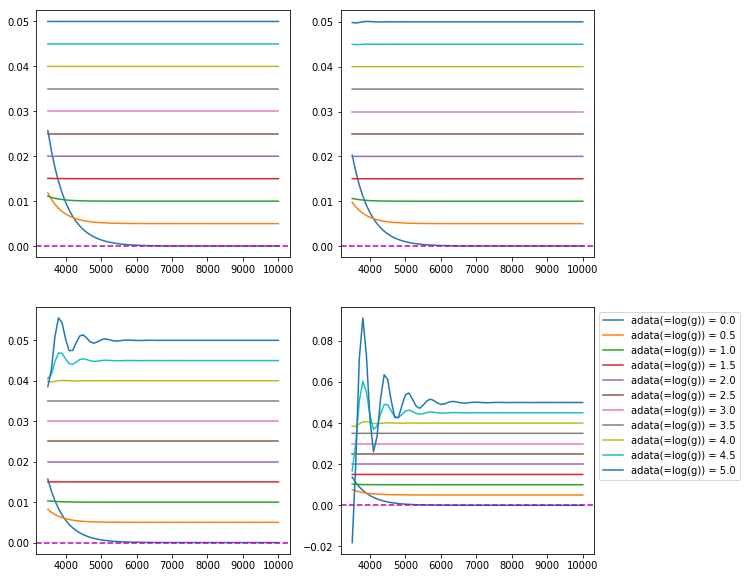

'(R*np.exp(comb_arr[x,i]*t))'

In [2]:
#damped oscillator tests
zeta1= 0.7

adata_list = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
logbdata_list = [-2.0,-1.0,0.0,0.5]

C = 0.01

comb_list = []
for m in adata_list:
    adata = m
    s2n_list = []
    for n in logbdata_list:
        bdata = n
        zeta2 = 0.1*(5.0-adata)**2 - 0.1*(bdata) + 0.2
        #print zeta2
        if (abs(zeta2) <= 1.0):
            s2 = -C*( zeta2 - 1.0j*np.sqrt(1 - (zeta2**2)) )
        else:
            # PROBLEM: if zeta2**2 > 1, gives nan rather than evaluating two imaginary numbers!
            s2 = -C*( zeta2 - np.sqrt((zeta2**2) - 1) )
        
        print 'log(g) = ',adata,', log(Z/Zsol) = ',bdata,', damping ratio = ',zeta2, ', decay coefficient = ',s2
        s2n_list.append(s2)
    #print s2n_list
    comb_list.append(s2n_list)
comb_arr = np.array(comb_list)

print type(comb_arr)
print comb_arr.shape
print comb_arr[:,0].shape
#print comb_arr

"""REMEMBER: damped_oscillator_gZ(input_params,Tcut,a,b,c,d,k):
    # exponential damping coefficient, function of zeta, the damping ratio
    # need zeta = zeta(g,Z)
    # Free parameters are: a,b,c,d,k
    
    Tdata,gdata,zdata = input_params
    
    zeta = a*(5.0-gdata) + b*zdata + c
    
    s = -d*( zeta + 1.0j*np.sqrt(1-zeta**2) )
    # 'Tdata' called below! - this should remove the need to use it anywhere in 'zeta'
    
    #R = a*(Tcut - Tdata)
    new_var = (k*(Tcut - Tdata))*np.exp(s*(Tcut-Tdata))
    return new_var
"""
#s1 = -C*( zeta1 + 1.0j*np.sqrt(1-zeta1**2) )
#y1 = np.exp(s1*t)

t = np.arange(3500,10100,100)
print type(t)
print max(t)

R = 0.002*(10000-t)

fgddfgg = 0
for a in range(len(comb_arr[:,0])):
    for b in range(len(comb_arr[0,:])):
        fgddfgg += 1
        #y2 = 1.0*np.exp(comb_arr[a,b]*t)
print fgddfgg

fig,ax = plt.subplots(2,2,figsize=(10, 10))
ax = ax.ravel()
print type(ax)
print comb_arr[0,0]
for i in range(len(ax)):
    #ax[i].plot(t,y1)
    for x in range(len(comb_arr[:,0])):
        ax[i].plot(t,((R*np.exp(comb_arr[x,i]*t)) + 0.01*adata_list[x]), label=('adata(=log(g)) = ' + str(adata_list[x])))
        
    ax[i].axhline(y=0, linestyle='--', color='m')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
"""(R*np.exp(comb_arr[x,i]*t))"""

In [3]:
# N.B.: using cgs unit
print 'Gaia data read '
print '\n'

# Gaia output
# Solar metallicity, Zsolar
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
# Zsolar/100
with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
      
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)
    
# Zsolar/10
with open ("gaia_spectra/OUTPUT_Av0_z10-1") as Av0z1:
    print '\n    Reading A(v) = 0, Z = (10^(-1) Zsolar) model'
    Av0z1_data = data_read_gaia(Av0z1)
      
with open ("gaia_spectra/OUTPUT_Av1_z10-1") as Av1z1:
    print '\n    Reading A(v) = 1, Z = (10^(-1) Zsolar) model'
    Av1z1_data = data_read_gaia(Av1z1)

# Zsolar*3 (really *10^0.5 = 3.162)
with open ("gaia_spectra/OUTPUT_Av0_z10+half") as Av0zh:
    print '\n    Reading A(v) = 0, Z = (10^(0.5) Zsolar) model'
    Av0zh_data = data_read_gaia(Av0zh)
      
with open ("gaia_spectra/OUTPUT_Av1_z10+half") as Av1zh:
    print '\n    Reading A(v) = 1, Z = (10^(0.5) Zsolar) model'
    Av1zh_data = data_read_gaia(Av1zh)

    
# dictionaries (Cardelli et al. Rv = 3.1)
# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'

# Zsolar
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
# Zsolar/100
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
# Zsolar/10
Av0z1_logg_fix,Av0z1_logg_vals = grid_vals_dict(Av0z1_data,2)
Av1z1_logg_fix,Av1z1_logg_vals = grid_vals_dict(Av1z1_data,2)
# Zsolar*3
Av0zh_logg_fix,Av0zh_logg_vals = grid_vals_dict(Av0zh_data,2)
Av1zh_logg_fix,Av1zh_logg_vals = grid_vals_dict(Av1zh_data,2)


print '****Separating data into arrays by Teff values****'

# Zsolar
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
# Zsolar/100
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)
# Zsolar/10
Av0z1_Teff_fix,Av0z1_Teff_vals = grid_vals_dict(Av0z1_data,1)
Av1z1_Teff_fix,Av1z1_Teff_vals = grid_vals_dict(Av1z1_data,1)
# Zsolar*3
Av0zh_Teff_fix,Av0zh_Teff_vals = grid_vals_dict(Av0zh_data,1)
Av1zh_Teff_fix,Av1zh_Teff_vals = grid_vals_dict(Av1zh_data,1)

print '****Finished arrays****'

# Final input data form: Ax/Av extinction ratios
Agaia_zs = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
Agaia_z2 = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)
Agaia_z1 = diff_grid_dict(Av0z1_logg_fix,Av1z1_logg_fix)
Agaia_zh = diff_grid_dict(Av0zh_logg_fix,Av1zh_logg_fix)

Agaia_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Agaia_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)
Agaia_z1_Teff_fix = diff_grid_dict(Av0z1_Teff_fix,Av1z1_Teff_fix)
Agaia_zh_Teff_fix = diff_grid_dict(Av0zh_Teff_fix,Av1zh_Teff_fix)


Teff_5_zs = (Agaia_zs['5.0'])[:,0]
# casagrande Teff ranges
casa_Teff,casa_T4 = casa_T4_range(((Agaia_zs['5.0'])[:,0]),5250,7000)
print casa_T4

# casagrande data
# zsolar
Rfil_G_zs = casa_Rfil_eq(casa_T4,'solar',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_zs = casa_Rfil_eq(casa_T4,'solar',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_zs = casa_Rfil_eq(casa_T4,'solar',1.8593,0.3985,-0.1771,0.0026)
# zsolar/100
Rfil_G_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.8593,0.3985,-0.1771,0.0026)
# zsolar/10
Rfil_G_z1 = casa_Rfil_eq(casa_T4,'sol_10',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_z1 = casa_Rfil_eq(casa_T4,'sol_10',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_z1 = casa_Rfil_eq(casa_T4,'sol_10',1.8593,0.3985,-0.1771,0.0026)
# zsolar*3
Rfil_G_zh = casa_Rfil_eq(casa_T4,'solx3',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_zh = casa_Rfil_eq(casa_T4,'solx3',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_zh = casa_Rfil_eq(casa_T4,'solx3',1.8593,0.3985,-0.1771,0.0026)

casa_arr_zs = casa_build(casa_Teff,Rfil_G_zs,Rfil_Gbp_zs,Rfil_Grp_zs)
casa_arr_z2 = casa_build(casa_Teff,Rfil_G_z2,Rfil_Gbp_z2,Rfil_Grp_z2)
casa_arr_z1 = casa_build(casa_Teff,Rfil_G_z1,Rfil_Gbp_z1,Rfil_Grp_z1)
casa_arr_zh = casa_build(casa_Teff,Rfil_G_zh,Rfil_Gbp_zh,Rfil_Grp_zh)

print casa_arr_zs.shape,casa_arr_z2.shape,casa_arr_z1.shape,casa_arr_zh.shape
print casa_arr_zs[:,2],casa_arr_z2[:,2]

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']

# strings describing functions being fitted to the data
fit_types = []

fit_types.append('Exponential function of Teff, fitted')
fit_types.append('Power law of Teff, fitted')
fit_types.append('Power law + exponential function of Teff, fitted')

# strings describing functions being fitted to the data FOR LOG(G)!
logg_fit_types = []

logg_fit_types.append('Quadratic in log(g), fitted')

product_fits = []
product_fits.append('Exponential function of Teff, fitted, plus Teff-log(g) product corrections')
product_fits.append('Power law of Teff, fitted, plus Teff-log(g) product corrections')
product_fits.append('Power law + exponential function of Teff, fitted, plus Teff-log(g) product corrections')
 
print 'Variable data arrays organized'

Gaia data read 



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476, 5)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476, 5)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476, 5)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476, 5)

    Reading A(v) = 0, Z = (10^(-1) Zsolar) model
Total dataset:  (476, 5)

    Reading A(v) = 1, Z = (10^(-1) Zsolar) model
Total dataset:  (476, 5)

    Reading A(v) = 0, Z = (10^(0.5) Zsolar) model
Total dataset:  (476, 5)

    Reading A(v) = 1, Z = (10^(0.5) Zsolar) model
Total dataset:  (476, 5)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Fina

Calculating coefficients & covariance matrices for G filter
Exponential fit coefficients: 
[-7.26537176e-01 -2.39457696e-04  1.02037816e+00]
Covariance matrix: 
[[3.71608808e-04 9.41806344e-08 8.32485346e-06]
 [9.41806344e-08 2.84916348e-11 4.17124972e-09]
 [8.32485346e-06 4.17124972e-09 1.91613755e-06]]
Teff^(n) fit coefficients: 
[-1.28137732e+04 -1.28185332e+00  1.04432504e+00]
Covariance matrix: 
[[4.83011336e+06 4.56905119e+01 2.88985684e+00]
 [4.56905119e+01 4.32846058e-04 2.78480806e-05]
 [2.88985684e+00 2.78480806e-05 2.44852371e-06]]
Teff^(n) + exponential fit coefficients: 
[-8.72670535e+00  9.09620848e-07  4.99870684e+00  2.99999321e+00
  4.97168206e-02]
Covariance matrix: 
[[ 8.03090160e+04  7.81377967e-03 -9.36498955e+04  1.25244889e+04
  -1.48886246e+02]
 [ 7.81377967e-03  7.60319611e-10 -9.10825053e-03  1.21528069e-03
  -1.44475330e-05]
 [-9.36498955e+04 -9.10825053e-03  1.09406834e+05 -1.47911437e+04
   1.75784422e+02]
 [ 1.25244889e+04  1.21528069e-03 -1.47911437e+04  

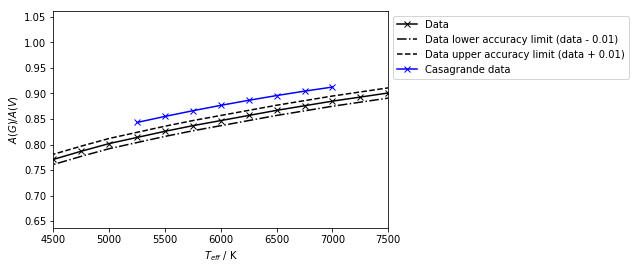


    Writing log(g)=5.0, Z = solx3 model
Average fractional error for Exponential function of Teff, fitted = 0.00029539552721130066
Average fractional error for Power law of Teff, fitted = 0.005450243446531674
Average fractional error for Power law + exponential function of Teff, fitted = 1019.5347516192654
Writing complete for G filter


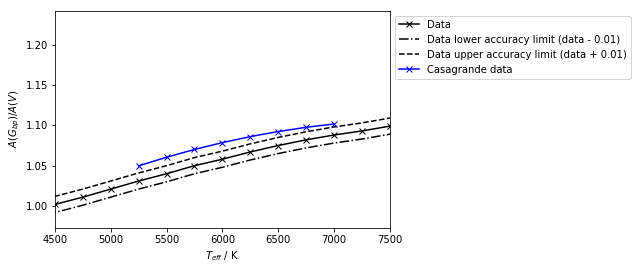


    Writing log(g)=5.0, Z = solx3 model
Average fractional error for Exponential function of Teff, fitted = 0.00039568685677088527
Average fractional error for Power law of Teff, fitted = 0.005685043879101982
Average fractional error for Power law + exponential function of Teff, fitted = 1561.441928965426
Writing complete for Gbp filter


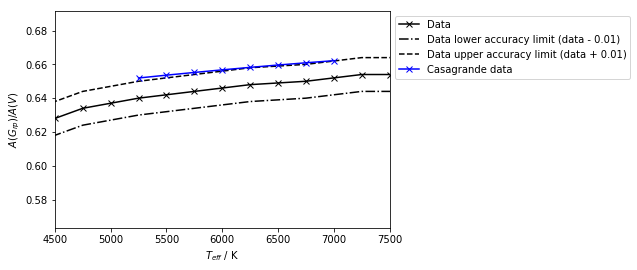


    Writing log(g)=5.0, Z = solx3 model
Average fractional error for Exponential function of Teff, fitted = 0.0015966594360590138
Average fractional error for Power law of Teff, fitted = 0.019556949363634463
Average fractional error for Power law + exponential function of Teff, fitted = 24188.711790079407
Writing complete for Grp filter

    Writing complete for log(g) = 5.0, Z = solx3 configuration, END OF FUNCTION WRITING!!!


In [8]:
# GAIA FILTER PLOTTING
# filter string names
gaia_filter_str = ['G','Gbp','Grp']
# curve fitting coefficients' bounds
exp_bounds_G = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 1., 5.])
plpe_bounds_G = ([-1.0e+02, -1., -5., -3., -2.], [1., 1., 5., 3., 2.])

exp_bounds_Gbp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Gbp = ([-1.0e+03, -3., -4.], [1., 3., 4.])
plpe_bounds_Gbp = ([-1.0e+02, -1., -5., -3., -2.], [1., 1., 5., 3., 2.])

exp_bounds_Grp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Grp = ([-1.0e+05, -4., -6.], [1., 4., 6.])
plpe_bounds_Grp = ([-1.0e+02, -1., -5., -3., -2.], [1., 1., 5., 3., 2.])

exp_bounds = [exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

#print exp_bounds
#print pow_bounds
#print plpe_bounds

# call function to general results

#metal_choice = 'sol_100'
combined_list_coef_cov = filter_curve_fit(Agaia_zs,'5.0',gaia_filter_str) # Leave key at '5.0'!!!
#print 'List of lists of arrays, length ',len(combined_list_coef_cov),'\n\n'
#filter_curve_plot_write(Agaia_zs,Agaia_z2,Agaia_z1,Agaia_zh,combined_list_coef_cov,'5.0','solx3','',gaia_filter_str,'gaia_spectra','gaia_graphs','y','n',4500,7500)


In [4]:
# N.B.: using cgs unit
print 'Hubble data read'
print '\n'

# Zsolar
with open ("HubWFC/H_OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_hub_data = data_read_gaia(Av0zs)

with open ("HubWFC/H_OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_hub_data = data_read_gaia(Av1zs)
    
# Zsolar/100
with open ("HubWFC/H_OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_hub_data = data_read_gaia(Av0z2)

with open ("HubWFC/H_OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_hub_data = data_read_gaia(Av1z2)
    
# Zsolar/10
with open ("HubWFC/H_OUTPUT_Av0_z10-1") as Av0z1:
    print '\n    Reading A(v) = 0, Z = (10^(-1) Zsolar) model'
    Av0z1_hub_data = data_read_gaia(Av0z1)

with open ("HubWFC/H_OUTPUT_Av1_z10-1") as Av1z1:
    print '\n    Reading A(v) = 1, Z = (10^(-1) Zsolar) model'
    Av1z1_hub_data = data_read_gaia(Av1z1)
    
# Zsolar*3 (really *10^0.5 = 3.162)
with open ("HubWFC/H_OUTPUT_Av0_z10+half") as Av0zh:
    print '\n    Reading A(v) = 0, Z = (10^(0.5) Zsolar) model'
    Av0zh_hub_data = data_read_gaia(Av0zh)

with open ("HubWFC/H_OUTPUT_Av1_z10+half") as Av1zh:
    print '\n    Reading A(v) = 1, Z = (10^(0.5) Zsolar) model'
    Av1zh_hub_data = data_read_gaia(Av1zh)
    
    
# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
# Zsolar
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_hub_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_hub_data,2)
# Zsolar/100
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_hub_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_hub_data,2)
# Zsolar/10
Av0z1_logg_fix,Av0z1_logg_vals = grid_vals_dict(Av0z1_hub_data,2)
Av1z1_logg_fix,Av1z1_logg_vals = grid_vals_dict(Av1z1_hub_data,2)
# Zsolar*3
Av0zh_logg_fix,Av0zh_logg_vals = grid_vals_dict(Av0zh_hub_data,2)
Av1zh_logg_fix,Av1zh_logg_vals = grid_vals_dict(Av1zh_hub_data,2)


Ahub_zs = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
Ahub_z2 = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)
Ahub_z1 = diff_grid_dict(Av0z1_logg_fix,Av1z1_logg_fix)
Ahub_zh = diff_grid_dict(Av0zh_logg_fix,Av1zh_logg_fix)

print '****Separating data into arrays by Teff values****'

# Zsolar
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_hub_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_hub_data,1)
# Zsolar/100
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_hub_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_hub_data,1)
# Zsolar/10
Av0z1_Teff_fix,Av0z1_Teff_vals = grid_vals_dict(Av0z1_hub_data,1)
Av1z1_Teff_fix,Av1z1_Teff_vals = grid_vals_dict(Av1z1_hub_data,1)
# Zsolar*3
Av0zh_Teff_fix,Av0zh_Teff_vals = grid_vals_dict(Av0zh_hub_data,1)
Av1zh_Teff_fix,Av1zh_Teff_vals = grid_vals_dict(Av1zh_hub_data,1)

Ahub_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Ahub_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)
Ahub_z1_Teff_fix = diff_grid_dict(Av0z1_Teff_fix,Av1z1_Teff_fix)
Ahub_zh_Teff_fix = diff_grid_dict(Av0zh_Teff_fix,Av1zh_Teff_fix)

print '****Finished arrays****'



# combined data dictionaries of arrays at fixed log(g) [default format!!!] and different fixed Z values
comb_dict_zs = comb_hub_gaia_dict(Ahub_zs,Agaia_zs)
comb_dict_z2 = comb_hub_gaia_dict(Ahub_z2,Agaia_z2)
comb_dict_z1 = comb_hub_gaia_dict(Ahub_z1,Agaia_z1)
comb_dict_zh = comb_hub_gaia_dict(Ahub_zh,Agaia_zh)

# combined data dictionaries of arrays at fixed Teff and different fixed Z values
comb_dict_Teff_zs = comb_hub_gaia_dict(Ahub_zs_Teff_fix,Agaia_zs_Teff_fix)
comb_dict_Teff_z2 = comb_hub_gaia_dict(Ahub_z2_Teff_fix,Agaia_z2_Teff_fix)
comb_dict_Teff_z1 = comb_hub_gaia_dict(Ahub_z1_Teff_fix,Agaia_z1_Teff_fix)
comb_dict_Teff_zh = comb_hub_gaia_dict(Ahub_zh_Teff_fix,Agaia_zh_Teff_fix)

# write out array of combined Hubble & Gaia data
#with open('Acombined_vals_solar_gfix','w') as f:
#    for key in comb_dict_zs:
#        f.write('log(g) = ' + key + ', Z=Zsol')
#        f.write(comb_dict_zs[key])
        
        
print type(comb_dict_zs),type(comb_dict_zs['0.0'])
print comb_dict_zs['0.0'].shape
print len(comb_dict_zs)

print comb_dict_Teff_zs['5000.0'].shape
print len(comb_dict_Teff_zs)

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']

# 'log($T_{eff}$ / K)'

# filter string names
hub_filter_str = ['f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w']
gaia_filter_str = ['G','Gbp','Grp']
comb_filter_str = hub_filter_str + gaia_filter_str

var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']

# Avoid tailflick filter artifacts: need Teff cutoff!
# log(g)-keyed dictionaries
comb_dict_zs_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4500.0)
comb_dict_z2_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4500.0)
comb_dict_z1_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z1,4500.0)
comb_dict_zh_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zh,4500.0)

#comb_dict_zs_4000K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4000.0)
#comb_dict_z2_4000K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4000.0)
#comb_dict_z1_4000K = Teff_cutoff_fix_logg_dict(comb_dict_z1,4000.0)
#comb_dict_zh_4000K = Teff_cutoff_fix_logg_dict(comb_dict_zh,4000.0)

# Teff-keyed dictionaries
comb_dict_Teff_zs_4500K = Teff_cutoff_fix_Teff_dict(comb_dict_Teff_zs,4500.0)
comb_dict_Teff_z2_4500K = Teff_cutoff_fix_Teff_dict(comb_dict_Teff_z2,4500.0)
comb_dict_Teff_z1_4500K = Teff_cutoff_fix_Teff_dict(comb_dict_Teff_z1,4500.0)
comb_dict_Teff_zh_4500K = Teff_cutoff_fix_Teff_dict(comb_dict_Teff_zh,4500.0)

print '4500K cutoff dict data shape: '
for key in sorted(comb_dict_zs_4500K.iterkeys()):
    print comb_dict_zs_4500K[key].shape
    
#print '4000K cutoff dict data shape: '
#for key in sorted(comb_dict_zs_4000K.iterkeys()):
#    print comb_dict_zs_4000K[key].shape
    
print 'Variable data arrays organized'

Hubble data read



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476, 15)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476, 15)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476, 15)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476, 15)

    Reading A(v) = 0, Z = (10^(-1) Zsolar) model
Total dataset:  (476, 15)

    Reading A(v) = 1, Z = (10^(-1) Zsolar) model
Total dataset:  (476, 15)

    Reading A(v) = 0, Z = (10^(0.5) Zsolar) model
Total dataset:  (476, 15)

    Reading A(v) = 1, Z = (10^(0.5) Zsolar) model
Total dataset:  (476, 15)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 

In [7]:
# HUBBLE FILTER PLOTTING

#print comb_filter_str
"""
# curve fitting coefficients' bounds
exp_bounds_f218w = ([-100., -2., -5.], [1., 2., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f218w = ([-1.0e+03, -2., -5., -1.0e+01, -1.], [1., 2., 5., 1., 1.])

exp_bounds_f225w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f225w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f275w = ([-1.0e+02, -4., -5., -1.0e+01, -5.], [1., 4., 5., 1., 5.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f300x = ([-1.0e+03, -2., -3., -1.0e+01, -3.], [1., 2., 3., 1., 3.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f336w = ([-1.0e+03, -3., -3., -1.0e+01, -3.], [1., 3., 3., 1., 3.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f390w = ([-1.0e+03, -1., -5., -1.0e+01, -4.], [1., 1., 5., 1., 4.])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f438w = ([-1.0e+03, -1., -5., -1.0e+01, -2.], [1., 1., 5., 1.0e+01, 2.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f475w = ([-1.0e+02, -1., -5., -1.0e+01, -5.], [1., 1., 5., 1., 5.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+05, -3., -5.], [1., 1., 5.])
plpe_bounds_f555w = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f606w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f625w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
plpe_bounds_f775w = ([-1.0e+03, -1., -5., -1.0e+01, -5.], [1., 1., 5., 1.0e+01, 5.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f814w = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_G = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
plpe_bounds_Gbp = ([-1.0e+02, -1., -3., -1.0e+01, -3.], [1., 1., 3., 1., 3.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
plpe_bounds_Grp = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_f218w,plpe_bounds_f225w,plpe_bounds_f275w,plpe_bounds_f300x,plpe_bounds_f336w,plpe_bounds_f390w,plpe_bounds_f438w,plpe_bounds_f475w,plpe_bounds_f555w,plpe_bounds_f606w,plpe_bounds_f625w,plpe_bounds_f775w,plpe_bounds_f814w,plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
print 'SOLAR METALLICITY FITTING'
combined_list_coef_cov_zs = filter_curve_fit(comb_dict_zs,'5.0',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs)"""

"\n# curve fitting coefficients' bounds\nexp_bounds_f218w = ([-100., -2., -5.], [1., 2., 5.])\npow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f218w = ([-1.0e+03, -2., -5., -1.0e+01, -1.], [1., 2., 5., 1., 1.])\n\nexp_bounds_f225w = ([-100., -1., -5.], [1., 1., 5.])\npow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f225w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])\n\nexp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])\npow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f275w = ([-1.0e+02, -4., -5., -1.0e+01, -5.], [1., 4., 5., 1., 5.])\n\nexp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])\npow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])\nplpe_bounds_f300x = ([-1.0e+03, -2., -3., -1.0e+01, -3.], [1., 2., 3., 1., 3.])\n\nexp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])\npow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])\nplpe_bounds_f336w = ([-1.0e+03, -3., -3., -1.0e+01, -3.], [1., 3., 3., 1

In [5]:
# 4500K Teff data cutoff HUBBLE FILTER PLOTTING

# curve fitting coefficients' bounds
exp_bounds_f218w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f218w = ([-1.0e+02, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_f225w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f225w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f275w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f300x = ([-1.0e+04, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f336w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+03, -1.0e-01, 1.], [1., 1.0e-02, 3.])
plpe_bounds_f390w = ([-1.0e+00, -1.0e-01, -3., -1.0e-01, -1.0e-01], [1., 0., 3., 1.0e-01, 1.0e-01])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f438w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f475w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 1.0e-01, 5., 1.0e-01, 1.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+06, -3., -5.], [1., 1., 5.])
plpe_bounds_f555w = ([-1.0e+01, -1.0e-02, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-02, 1.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f606w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+06, -3., -5.], [1., 3., 5.])
plpe_bounds_f625w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
plpe_bounds_f775w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 1.0e-01, 6., 1.0e-01, 1.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f814w = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_G = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
plpe_bounds_Gbp = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
plpe_bounds_Grp = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_f218w,plpe_bounds_f225w,plpe_bounds_f275w,plpe_bounds_f300x,plpe_bounds_f336w,plpe_bounds_f390w,plpe_bounds_f438w,plpe_bounds_f475w,plpe_bounds_f555w,plpe_bounds_f606w,plpe_bounds_f625w,plpe_bounds_f775w,plpe_bounds_f814w,plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!

print 'SOLAR METALLICITY FITTING'

combined_list_coef_cov_zs_4500K = filter_curve_fit(comb_dict_zs_4500K,'5.0',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs_4500K)
"""

combined_list_coef_cov_zs_full = filter_curve_fit(comb_dict_zs,'5.0',comb_filter_str)
print 'List of lists of arrays for full data-Teff range, length ',len(combined_list_coef_cov_zs_full)"""

SOLAR METALLICITY FITTING
Calculating coefficients & covariance matrices for f218w filter
Exponential fit coefficients: 
[-2.32239583e+02 -1.07618486e-03  2.93335416e+00]
Covariance matrix: 
[[2.30119864e+03 2.04691908e-03 1.03317848e-01]
 [2.04691908e-03 1.83718621e-09 1.01315930e-07]
 [1.03317848e-01 1.01315930e-07 4.83379040e-05]]
Teff^(n) fit coefficients: 
[-1.00000000e+08 -2.16845377e+00  3.03078630e+00]
Covariance matrix: 
[[7.81892609e+16 9.16463883e+07 6.92277615e+06]
 [9.16463883e+07 1.07494605e-01 8.25122202e-03]
 [6.92277615e+06 8.25122202e-03 1.26279419e-03]]
Teff^(n) + exponential fit coefficients: 
[-49.5         -0.06712196   0.42621227   1.           0.09010763]
Covariance matrix: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.55851144e-24 -3.15093570e-11  2.46550666e-11
  -1.18346335e-12]
 [ 0.00000000e+00 -3.15093570e-11  3.88062334e+02 -3.03628374e+02
   1.45734430e+01]
 [ 0.00000000e+00  2.46550666e-11 -3.

Calculating coefficients & covariance matrices for f555w filter
Exponential fit coefficients: 
[-2.17062286e-01 -3.00634319e-04  1.07768556e+00]
Covariance matrix: 
[[7.86215455e-05 6.13729018e-08 8.03383641e-07]
 [6.13729018e-08 5.21794237e-11 9.39154298e-10]
 [8.03383641e-07 9.39154298e-10 5.95197435e-08]]
Teff^(n) fit coefficients: 
[-4.87067534e+05 -1.88731295e+00  1.07982299e+00]
Covariance matrix: 
[[2.07426943e+10 4.99426302e+03 2.63611329e+01]
 [4.99426302e+03 1.20347123e-03 6.45627069e-06]
 [2.63611329e+01 6.45627069e-06 6.06444894e-08]]
Teff^(n) + exponential fit coefficients: 
[-4.50000004 -0.00499881  1.10352034 -0.09999999 -0.10575743]
Covariance matrix: 
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.69497037e+07 1.17518260e+03 1.46516705e+02
  3.53761548e+03]
 [0.00000000e+00 1.17518260e+03 4.54307525e-01 3.08611579e-02
  1.34188081e+00]
 [0.00000000e+00 1.46516705e+02 3.08611579e-02 5.46878618e-03
  9.46419416e-02]
 [0

"\n\ncombined_list_coef_cov_zs_full = filter_curve_fit(comb_dict_zs,'5.0',comb_filter_str)\nprint 'List of lists of arrays for full data-Teff range, length ',len(combined_list_coef_cov_zs_full)"


    Writing log(g)=5.0, Z = sol_100 model for f218w filter
Average fractional error for Exponential function of Teff, fitted = 0.00878879567624
Average fractional error for Power law of Teff, fitted = 1.3831642575
Average fractional error for Power law + exponential function of Teff, fitted = 32.7945448525

    Writing log(g)=5.0, Z = sol_100 model for f225w filter
Average fractional error for Exponential function of Teff, fitted = 0.00239641299469
Average fractional error for Power law of Teff, fitted = 0.808095638047
Average fractional error for Power law + exponential function of Teff, fitted = 7935.31734713

    Writing log(g)=5.0, Z = sol_100 model for f275w filter
Average fractional error for Exponential function of Teff, fitted = 0.00105540352195
Average fractional error for Power law of Teff, fitted = 0.0292078769595
Average fractional error for Power law + exponential function of Teff, fitted = 29.7444354869

    Writing log(g)=5.0, Z = sol_100 model for f300x filter
Average 

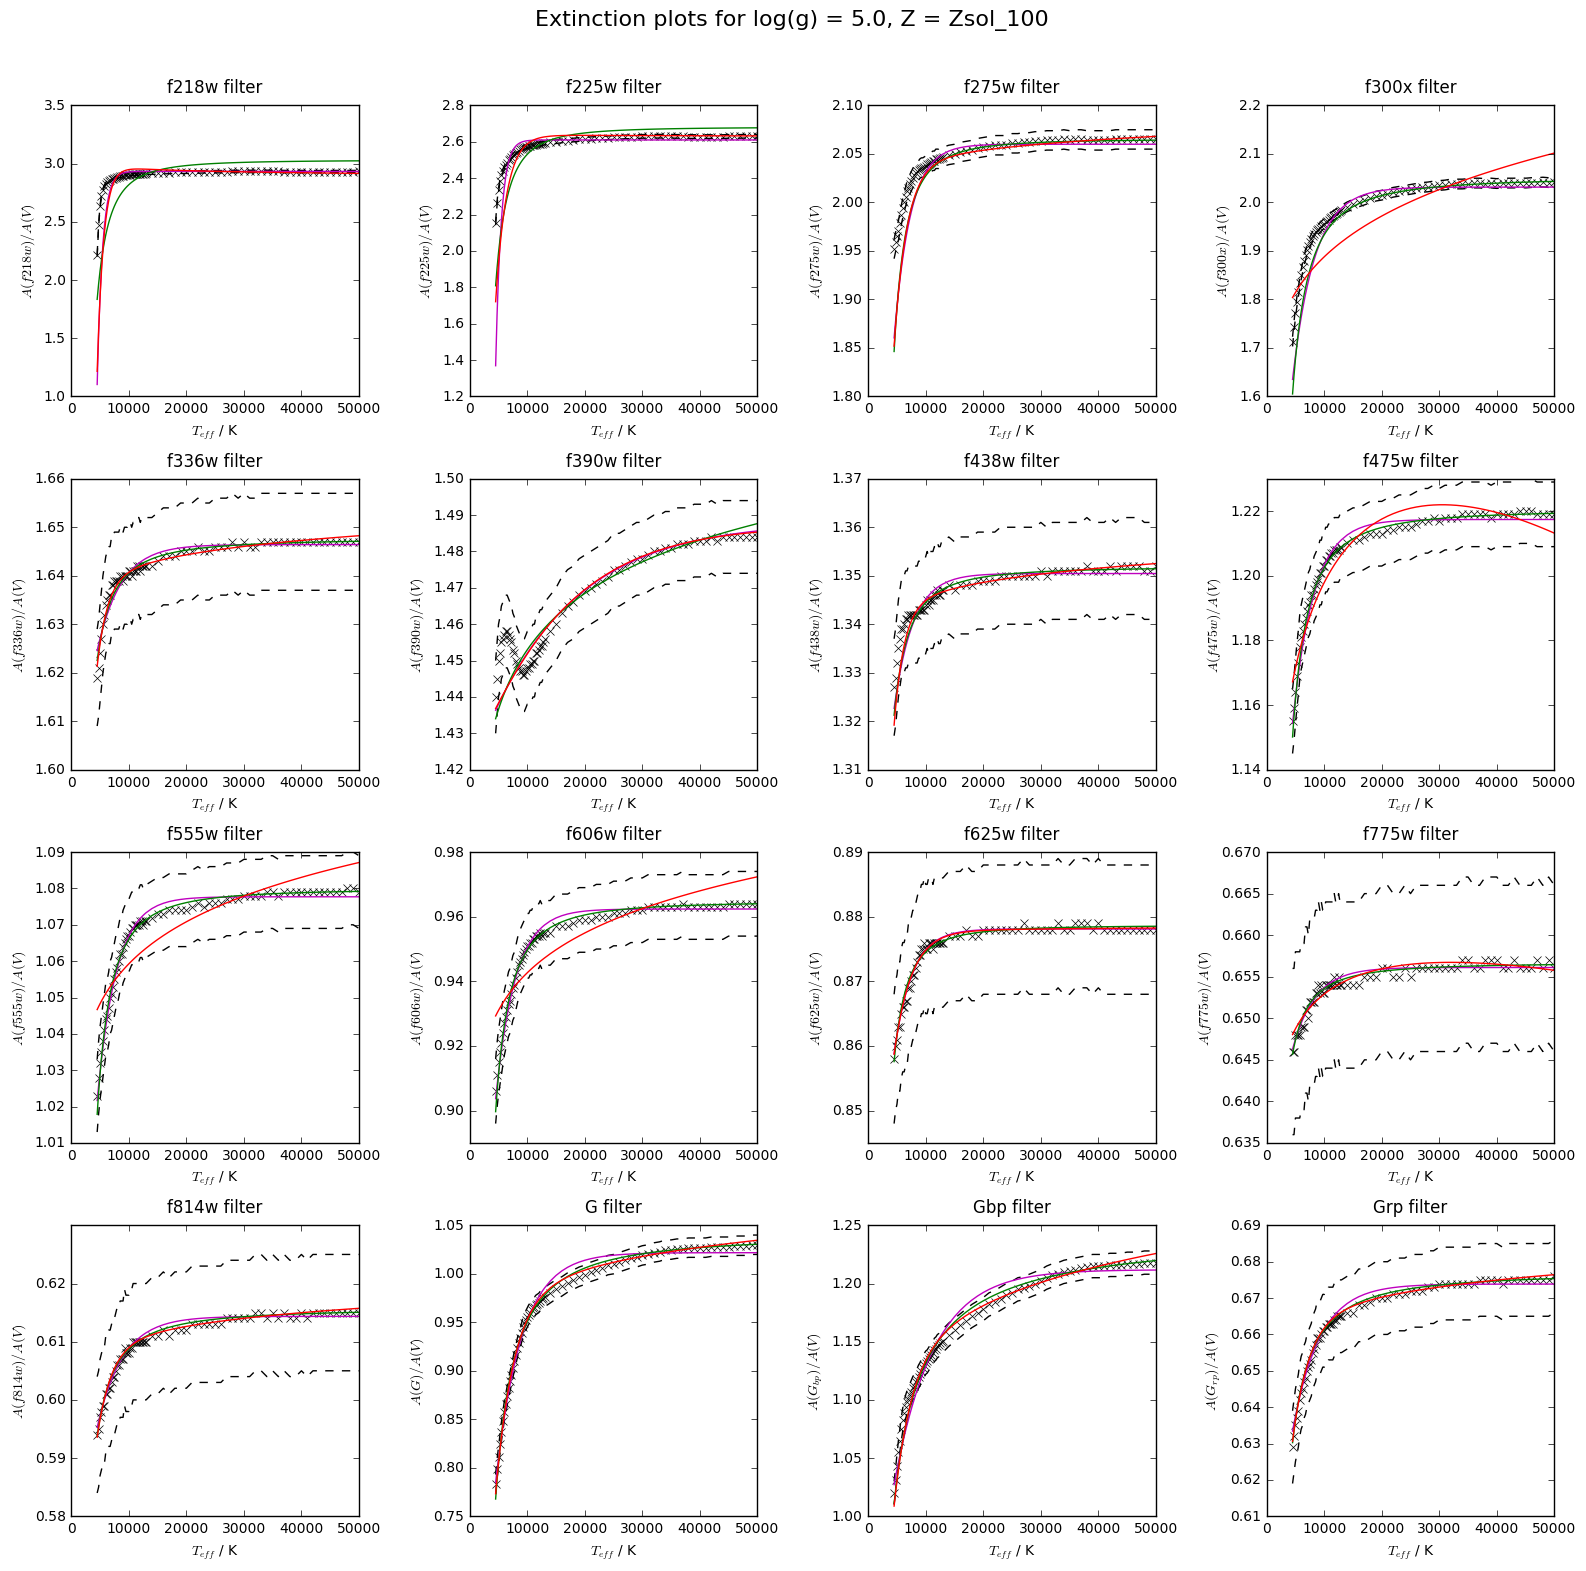


    Writing complete for log(g) = 5.0, Z = sol_100 configuration, END OF FUNCTION WRITING!!!


In [122]:
# If finished fitting (i.e. log(g) not equal to 5.0), DON'T run previous cell!!!

# Test solar metallicity fit on BOTH metallicity scenarios
filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_zs_4500K,'5.0','sol_100','4500K',comb_filter_str,'HubWFC','Hub_graphs','n','y')
#filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_z2_4500K,'5.0','solar','4500K',comb_filter_str,'HubWFC','Hub_graphs','n','y')
# ,8000,20000
#,4400,6000

In [25]:
#test_out_function = single_poly(comb_dict_zs_4500K['5.0'], -1.0e+05, -2., -5.)
#print test_out_function.shape
# Create coefficient summary text file for power law
# filename options:
# IN: metallicity: solar, sol_100
# OUT: metallicity: solar, solar/100
"""
print len(comb_filter_str)
make_coeffs_summary('HubWFC/','Teff_AHub_gaia_gen_fit_logg=5.0_sol_100_numbers.txt','coeffs_hub_gaia_power.txt',comb_filter_str,'5.0','solar/100','a')
"""

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects
        
"""
with open('pred_combined_dict_example.txt','w') as f:
    for key in sorted(combined_prediction_dict_zs_4500K.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,combined_prediction_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '
        f.write('\n')
    f.close()

with open('pred_Teff_dict_example.txt','w') as f:
    for key in sorted(Teff_predition_dict_zs_4500K.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,Teff_predition_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '
        f.write('\n')
    f.close()

# set the Teff-value for which log(g) coefficients are calculated, using argument in function call
    # combined prediction COEFFICIENTS!
    logg_plus_Teff_pred = combined_pred_dict[logg_pred_teff_val]
    # Teff-only prediction COEFFICIENTS!
    Teff_only_pred = Teff_pred_dict[logg_pred_teff_val]

print comb_dict_zs_4500K['0.0'][0,:]
#print comb_dict_zs_4500K['0.5'][0,:]
#print combined_prediction_dict_zs_4500K['0.0'][0,:]
fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
axs = axs.ravel()
#_4500K
test_arr = comb_dict_zs['3.0']
test_arr_4500K = comb_dict_zs_4500K['3.0']
test_arr_4000K = comb_dict_zs_4000K['3.0']
for i in range(2,18):
    axs[i-2].plot(test_arr[:,0],test_arr[:,i],'r',marker='x')
    axs[i-2].plot(test_arr_4000K[:,0],test_arr_4000K[:,i],'b',marker='x')
    axs[i-2].plot(test_arr_4500K[:,0],test_arr_4500K[:,i],'g',marker='x')
plt.show()
"""

# write examples of dictionaries' formats
"""
with open('diff_dict_fixed_logg_example.txt','w') as f:
    for key in sorted(comb_logg_zs_4500K_diff.iterkeys()):
        f.write('Array for log(g) = ' + key + '\n')
        f.write('Shape: '+ str(comb_logg_zs_4500K_diff[key].shape) + '\n')
        f.write('Array has the following Teff values: ')
        for i in range(len(comb_logg_zs_4500K_diff[key][:,0])):
            f.write(str(comb_logg_zs_4500K_diff[key][i,0]) + ' ')
        f.write('\n' + str(comb_logg_zs_4500K_diff[key]) + '\n')
        f.write('\n')
    f.close()


# Fixed Teff format (to get log(g) coefficients)
with open('dict_fixed_Teff_example.txt','w') as f:#comb_Teff_zs_sort
    for key in sorted(comb_dict_Teff_zs.iterkeys()):
        if (key[0] == '0'):
            tidy_key = key[1:]
            f.write('Array for Teff = ' + tidy_key + '\n')
        else:
            f.write('Array for Teff = ' + key + '\n')
        f.write('Shape: '+ str(comb_dict_Teff_zs[key].shape) + '\n')#,' by ',str(comb_Teff_zs_sort[key].shape[1])
        f.write('Array has the following log(g) values: ')
        for i in range(len(comb_dict_Teff_zs[key][:,1])):
            f.write(str(comb_dict_Teff_zs[key][i,1]) + ' ')
        f.write('\n' + str(comb_dict_Teff_zs[key]) + '\n')
        f.write('\n')
    f.close()

# Difference dictionary for fixed Teff format data (to get log(g) coefficients)
with open('diff_dict_fixed_Teff_bounds_example.txt','w') as f:
    for key in sorted(comb_Teff_zs_sort_diff_4500_50000.iterkeys()):
        if (key[0] == '0'):
            tidy_key = key[1:]
            f.write('Array for Teff = ' + tidy_key + '\n')
        else:
            f.write('Array for Teff = ' + key + '\n')
        f.write('Shape: '+ str(comb_Teff_zs_sort_diff_4500_50000[key].shape) + '\n')#,' by ',str(comb_Teff_zs_sort[key].shape[1])
        f.write('Array has the following log(g) values: ')
        for i in range(len(comb_Teff_zs_sort_diff_4500_50000[key][:,1])):
            f.write(str(comb_Teff_zs_sort_diff_4500_50000[key][i,1]) + ' ')
        f.write('\n' + str(comb_Teff_zs_sort_diff_4500_50000[key]) + '\n')
        f.write('\n')
    f.close()
"""               

(72L, 18L)


"\nwith open('pred_combined_dict_example.txt','w') as f:\n    for key in sorted(combined_predition_dict_zs_4500K.iterkeys()):\n        f.write('Dictionary for log(g) = ' + key + '\n')\n        np.savetxt(f,combined_predition_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '\n        f.write('\n')\n    f.close()\n\nwith open('pred_Teff_dict_example.txt','w') as f:\n    for key in sorted(Teff_predition_dict_zs_4500K.iterkeys()):\n        f.write('Dictionary for log(g) = ' + key + '\n')\n        np.savetxt(f,Teff_predition_dict_zs_4500K[key])#,fmt='%6.1f %4.1f %6.3f %6.3f %6.3f',delimiter='   '\n        f.write('\n')\n    f.close()\n\n# set the Teff-value for which log(g) coefficients are calculated, using argument in function call\n    # combined prediction COEFFICIENTS!\n    logg_plus_Teff_pred = combined_pred_dict[logg_pred_teff_val]\n    # Teff-only prediction COEFFICIENTS!\n    Teff_only_pred = Teff_pred_dict[logg_pred_teff_val]\n\nprint comb_dict_zs_4500K['0.0

In [6]:
var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']
best_fits_filterwise = ['exp','exp','exp','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow','pow']
print len(best_fits_filterwise)
#comb_dict_zs_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4500.0)
# solar metallicity
comb_Teff_zs_4500K_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_zs_4500K_sort_diff = {}
comb_logg_zs_4500K_diff = {}

# solar/100 metallicity
comb_Teff_z2_4500K_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_z2_4500K_sort_diff = {}
comb_logg_z2_4500K_diff = {}

# solar/10 metallicity
comb_Teff_z1_4500K_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_z1_4500K_sort_diff = {}
comb_logg_z1_4500K_diff = {}

# solar*10^(0.5) metallicity
comb_Teff_zh_4500K_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_zh_4500K_sort_diff = {}
comb_logg_zh_4500K_diff = {}

# Combining the two effects
# Teff-only coefficients lists
exp_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[0]
exp_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[1]
pow_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[2]
pow_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[3]
plpe_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[4]
plpe_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[5]

# Following line gives: number of filters, number of coeffs for function (apply to each filter)
# Total number of Teff-only curves produced earlier = 16x3 = 48 -> 48 sets of coefficients, 48 covariance matrices
print len(exp_Teff_coef_4500K_logg_5),len(exp_Teff_coef_4500K_logg_5[0])

#comb_dict_z2_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4500.0)


# Take 'best' functions for each filter and generate their outputs for the Teff points covered (i.e., the curves plotted in the final graphs)
R1_sim_points_dict = make_sim_Teff_R1_array(comb_dict_zs_4500K,best_fits_filterwise)
R1_sim_points_dict_full = make_sim_Teff_R1_array(comb_dict_zs,best_fits_filterwise)

# properly ordered sorting for  Teff-keyed data
for old_key in comb_dict_Teff_zs_4500K:
    new_key = old_key.zfill(7)
    comb_Teff_zs_4500K_sort[new_key] = np.copy(comb_dict_Teff_zs_4500K[old_key])
    comb_Teff_z2_4500K_sort[new_key] = np.copy(comb_dict_Teff_z2_4500K[old_key])
    comb_Teff_z1_4500K_sort[new_key] = np.copy(comb_dict_Teff_z1_4500K[old_key])
    comb_Teff_zh_4500K_sort[new_key] = np.copy(comb_dict_Teff_zh_4500K[old_key])

# dictionaries of difference values from log(g) = 5.0 - FOR RELEVANT (LOW) TEFF VALUES 
comb_Teff_zs_4500K_sort_diff = diff_from_ref_Teff_key(comb_Teff_zs_4500K_sort,8000.0)
comb_Teff_z2_4500K_sort_diff = diff_from_ref_Teff_key(comb_Teff_z2_4500K_sort,8000.0)
comb_Teff_z1_4500K_sort_diff = diff_from_ref_Teff_key(comb_Teff_z1_4500K_sort,8000.0)
comb_Teff_zh_4500K_sort_diff = diff_from_ref_Teff_key(comb_Teff_zh_4500K_sort,8000.0)

comb_logg_zs_4500K_diff = diff_from_ref_logg_key(comb_dict_zs_4500K,R1_sim_points_dict,Teff_max_lim=8000.0,ref_sim_yn='n')#
comb_logg_z2_4500K_diff = diff_from_ref_logg_key(comb_dict_z2_4500K,R1_sim_points_dict,Teff_max_lim=8000.0,ref_sim_yn='n')#

comb_logg_zs_4500K_diff_sim = diff_from_ref_logg_key(comb_dict_zs_4500K,R1_sim_points_dict,Teff_max_lim=8000.0,ref_sim_yn='y')#
comb_logg_z2_4500K_diff_sim = diff_from_ref_logg_key(comb_dict_z2_4500K,R1_sim_points_dict,Teff_max_lim=8000.0,ref_sim_yn='y')#

print 'Cut dictionary ',len(comb_logg_zs_4500K_diff)
print 'Cut dictionary number of Teffs:',len(comb_logg_zs_4500K_diff['2.0'][:,0])
for k in comb_logg_zs_4500K_diff['5.0'][:,0]:
    print k
#for y in sorted(comb_Teff_zs_sort_diff.iterkeys()):
#    print y
#print 'pause'
#for x in sorted(comb_Teff_zs_sort_diff_4500_50000.iterkeys()):
#    print x
# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)

quad_bounds = ([-5.,-5.,-10.],[5.,5.,10.])
""" REMEMBER THE FUNCTION'S FORM!
    Teff_logg_product_func(Tdata,gdata,a,b,c):
        y = a*(Tdata*gdata) + b*gdata + c
        return y"""
Tlgp_bounds = ([-1.0e-02,-0.01,-2.0],[1.0e-02,3.0,2.0])
start_coords = [-1.0e-05,1.0,0.0]
#  log(g)-only function
#logg_coeffs_dict_zs_Teff_4500,logg_cov_dict_zs_Teff_4500 = logg_coeffs_calc('coeffs_logg_zs_4500_50000.txt',comb_Teff_zs_4500K_sort_diff,quad_func,quad_bounds,comb_filter_str)
#print 'Syncing the log(g)-only functions with main (Teff-only) function'

# for final combined adjustment function, set modulation power-index
Tmod_power = 1.0
# add extra Teff effect to give new combined-parameters function #_sim
comb_R2_coeffs_dict_zs_Teff_4500,comb_R2_cov_dict_zs_Teff_4500 = all_params_combined_coeffs_calc('coeffs_comb_R2_zs_4500_50000.txt',comb_logg_zs_4500K_diff,Teff_logg_product_func,Tlgp_bounds,comb_filter_str,start_coords,Tmod_power)
print 'Syncing the combined Teff-log(g) functions with main (Teff-only) function'
for u in comb_R2_coeffs_dict_zs_Teff_4500['4.5']:
    print u

ind_Tlgp_bounds = ([0.0,-1.0e-02,-0.01,-2.0],[2.0,1.0e-02,3.0,2.0])
ind_start_coords = [Tmod_power,-1.0e-05,1.0,0.0]

ind_comb_R2_coeffs_dict_zs_Teff_4500,ind_comb_R2_cov_dict_zs_Teff_4500 = all_params_combined_coeffs_calc('ind_coeffs_comb_R2_zs_4500_50000.txt',comb_logg_zs_4500K_diff,Teff_logg_product_func,ind_Tlgp_bounds,comb_filter_str,ind_start_coords,Tmod_power,model_tmod_yn='y')
print 'Syncing the combined Teff-log(g) functions with main (Teff-only) function'
for u in ind_comb_R2_coeffs_dict_zs_Teff_4500['4.5']:
    print u
#,comb_R2_coeffs_dict_zs_Teff_4500['4.5'][u]


# Carry out syncing

#logg_Avals_pred_dict_zs_4500K,Teff_logg_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,logg_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise,8000.0)
#print 'Finished log(g)-only sync'
combined_Avals_pred_dict_zs_4500K,Teff_comb_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,comb_R2_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise,Teff_logg_product_func,Tmod_power,8000.0)
ind_combined_Avals_pred_dict_zs_4500K,ind_Teff_comb_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,ind_comb_R2_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise,Teff_logg_product_func,Tmod_power,8000.0,model_tmod_yn='y')

print 'Finished Teff-log(g) combination sync'

print len(comb_dict_zs_4500K),' , ',len(combined_Avals_pred_dict_zs_4500K)
print (comb_dict_zs_4500K['5.0']).shape,' , ',(combined_Avals_pred_dict_zs_4500K['5.0']).shape

print len(comb_dict_zs_4500K),' , ',len(ind_combined_Avals_pred_dict_zs_4500K)
print (comb_dict_zs_4500K['5.0']).shape,' , ',(ind_combined_Avals_pred_dict_zs_4500K['5.0']).shape

# Note: len(logg_coeffs_dict_zs_Teff_4500['04500.0']) = 16!!!
#print type(logg_coeffs_dict_zs_Teff_4500['04500.0'][0])
#print logg_coeffs_dict_zs_Teff_4500['04500.0'][0]
print len(comb_R2_coeffs_dict_zs_Teff_4500)
print len(ind_comb_R2_coeffs_dict_zs_Teff_4500)
print len((comb_dict_zs_4500K['5.0'])[:,0])

print (comb_Teff_zs_4500K_sort_diff)['04500.0'].shape
Teff_vals_arr = from_keys_get_numerical_data(comb_Teff_zs_4500K_sort_diff)
print Teff_vals_arr
logg_vals_arr = from_keys_get_numerical_data(comb_dict_zs_4500K)
print logg_vals_arr

print 'combined stuff working SO FAR!!!'

16
16 3
Cut dictionary  11
Cut dictionary number of Teffs: 15
4500.0
4750.0
5000.0
5250.0
5500.0
5750.0
6000.0
6250.0
6500.0
6750.0
7000.0
7250.0
7500.0
7750.0
8000.0
Temperatures to (maybe) be anchors:  4500.0 [6000.] 8000.0
index line-up:  1.0 4500.0
index line-up:  1.0 4750.0
index line-up:  0.01 5000.0
index line-up:  1.0 5250.0
index line-up:  1.0 5500.0
index line-up:  1.0 5750.0
index line-up:  0.01 6000.0
index line-up:  1.0 6250.0
index line-up:  1.0 6500.0
index line-up:  1.0 6750.0
index line-up:  1.0 7000.0
index line-up:  1.0 7250.0
index line-up:  1.0 7500.0
index line-up:  1.0 7750.0
index line-up:  0.001 8000.0
Maximum temperature of Teff_only_dict[5.0]:  8000.0
Temperatures to (maybe) be anchors:  4500.0 [6000.] 8000.0
Maximum temperature of Teff_only_dict[4.5]:  8000.0
Max occurs at the following index:  14
4.5 f218w Coefficients : [-1.40890777e-06  1.00195990e+00 -8.43156771e-04]
Test output at 8000K:  -0.0008431567707568136
Max occurs at the following index:  14


/Users/alex/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


4.5 f225w Coefficients : [-5.07609825e-07  1.00231534e+00  2.31926406e-03]
Test output at 8000K:  0.0023192640581471994
Max occurs at the following index:  14
4.5 f275w Coefficients : [-2.52664446e-06  1.00160119e+00  1.15324238e-03]
Test output at 8000K:  0.0011532423844091363
Max occurs at the following index:  14
4.5 f300x Coefficients : [ 4.39034915e-06  1.00295730e+00 -2.39415648e-03]
Test output at 8000K:  -0.0023941564835849387
Max occurs at the following index:  14
4.5 f336w Coefficients : [ 2.97820316e-07  1.00183806e+00 -3.50622864e-04]
Test output at 8000K:  -0.0003506228635743239
Max occurs at the following index:  14
4.5 f390w Coefficients : [ 2.20844245e-06  1.00230384e+00 -2.63051712e-03]
Test output at 8000K:  -0.002630517123727817
Max occurs at the following index:  14
4.5 f438w Coefficients : [1.58237317e-09 1.01053374e+00 4.69960904e-04]
Test output at 8000K:  0.00046996090415412804
Max occurs at the following index:  14
4.5 f475w Coefficients : [-1.22580694e-06  1.0

In [56]:
# try for multiple deltaT terms in correction function - i.e., f(deltaT**x) + g(deltaT**(x-1))
poly_Tlgp_bounds = ([-1.0e-04,-1.0e-04],[0.0,0.0])
poly_start_coords = [0.0,0.0]

"""REMEMBER: Teff_logg_polynomial(Tdata,Tcut,gdata,a,b,c=0.0,d=2):
    # note: want b (power) to be integer!
    y = ((a*(Tcut-Tdata)**d + b*(Tcut-Tdata)**(d-1))*(5.0-gdata)) + c
    return y"""

poly_comb_R2_coeffs_dict_zs_Teff_4500,poly_comb_R2_cov_dict_zs_Teff_4500 = all_params_combined_coeffs_calc('poly_coeffs_comb_R2_zs_4500_50000.txt',comb_logg_zs_4500K_diff,Teff_logg_polynomial,poly_Tlgp_bounds,comb_filter_str,poly_start_coords,Tmod_power,model_tmod_yn='y')

poly_combined_Avals_pred_dict_zs_4500K,poly_Teff_comb_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,poly_comb_R2_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise,Teff_logg_polynomial,Tmod_power,8000.0,model_tmod_yn='y')

print 'Syncing the combined Teff-log(g) functions with main (Teff-only) function'
for u in poly_comb_R2_coeffs_dict_zs_Teff_4500['4.5']:
    print u

Temperatures to (maybe) be anchors:  4500.0 [ 6000.] 8000.0
index line-up:  1.0 4500.0
index line-up:  1.0 4750.0
index line-up:  0.01 5000.0
index line-up:  1.0 5250.0
index line-up:  1.0 5500.0
index line-up:  1.0 5750.0
index line-up:  0.01 6000.0
index line-up:  1.0 6250.0
index line-up:  1.0 6500.0
index line-up:  1.0 6750.0
index line-up:  1.0 7000.0
index line-up:  1.0 7250.0
index line-up:  1.0 7500.0
index line-up:  1.0 7750.0
index line-up:  0.001 8000.0
Maximum temperature of Teff_only_dict[5.0]:  8000.0
Temperatures to (maybe) be anchors:  4500.0 [ 6000.] 8000.0
Maximum temperature of Teff_only_dict[4.5]:  8000.0
Max occurs at the following index:  14
4.5 f218w Coefficients : [ -1.06560759e-09  -9.44945151e-18]
Test output at 8000K:  0.0
Max occurs at the following index:  14
4.5 f225w Coefficients : [ -2.95797584e-20  -7.10308242e-21]
Test output at 8000K:  0.0
Max occurs at the following index:  14
4.5 f275w Coefficients : [ -6.41549842e-10  -9.95835491e-11]
Test output a

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:211: RuntimeWarning: divide by zero encountered in reciprocal
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:211: RuntimeWarning: invalid value encountered in multiply


In [11]:
def simple_func(V,a,b,c):
    t,g,z = V
    return a*t + b*g + c*z

t = np.linspace(1.0,10.0,10)
g = np.linspace(2.0,20.0,10)
z = np.linspace(0.5,5.0,10)
print 't=', t
print 'g=', g
print 'z=', z
a,b,c = 5.0, 3.0, 9.0

print simple_func((t,g,z),1.,1.,1.)
#A = simple_func((t,g,z),a,b,c) + np.random.random(101) / 100
#p0 = [4.,5.,7.]
#print curve_fit(simple_func,(t,g,z),A,p0)

t= [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
g= [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
z= [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 3.5  7.  10.5 14.  17.5 21.  24.5 28.  31.5 35. ]


In [16]:
# damped oscillator model for Teff,logg,Z
dosc_Tlgp_bounds = ([-1.0e-04,-1.0e-04],[0.0,0.0])
dosc_start_coords = [0.0,0.0]


# Calculate & truncate residuals from Round 1 fitting to be restricted to Teff <= 15000K
R2_Tmax = 15000

R1_residuals_zs_15000K = diff_from_ref_logg_key(comb_dict_zs,R1_sim_points_dict_full,R2_Tmax,'y')
R1_residuals_z1_15000K = diff_from_ref_logg_key(comb_dict_z1,R1_sim_points_dict_full,R2_Tmax,'y')
R1_residuals_z2_15000K = diff_from_ref_logg_key(comb_dict_z2,R1_sim_points_dict_full,R2_Tmax,'y')
R1_residuals_zh_15000K = diff_from_ref_logg_key(comb_dict_zh,R1_sim_points_dict_full,R2_Tmax,'y')

# Create 'super-dictionary' for all 3 input variables
R1_residuals_all_3inputs_data_15000K = {
    '0.0': R1_residuals_zs_15000K,
    '-1.0': R1_residuals_z1_15000K,
    '-2.0': R1_residuals_z2_15000K,
    '0.5': R1_residuals_zh_15000K,
}

# for key in sorted(comb_dict_zs_4500K.iterkeys())
all3pars_it = 0
big_data_arr = np.array([], dtype=np.float64).reshape(0,19)
print big_data_arr.shape

for zkey in sorted(R1_residuals_all_3inputs_data_15000K.iterkeys()):
    print zkey
    res_dict_zk = R1_residuals_all_3inputs_data_15000K[zkey]
    for gkey in sorted(res_dict_zk.iterkeys()):
        all3pars_it += 1
        res_dict_at_1g1z = res_dict_zk[gkey]
        test_arr = np.insert(res_dict_at_1g1z,2,float(zkey),axis=1)
        #print type(res_dict_at_1g1z), res_dict_at_1g1z.shape, test_arr.shape
        big_data_arr = np.concatenate((big_data_arr,test_arr),axis=0)
    #print big_data_arr.shape,'\n'
print all3pars_it

print big_data_arr.shape
    
#with open('final_all_data_TgZ_Aall.txt','w') as f:
#    np.savetxt(f,big_data_arr,fmt='%6.1f %4.1f %4.1f '+16*'%6.5f ')#,delimiter='   '
#    f.close()  

(0, 19)
-1.0
-2.0
0.0
0.5
44
(1408, 19)


In [41]:
# NOTE: multiplying 2 numpy arrays together does NOT give a result with a different array shape
"""REMEMBER: damped_oscillator_gZ(input_params,Tcut,a,b,c,d,k):
    # exponential damping coefficient, function of zeta, the damping ratio
    # need zeta = zeta(g,Z)
    # Free parameters are: a,b,c,d,k
    
    Tdata,gdata,zdata = input_params
    
    zeta = a*(5.0-gdata) + b*zdata + c
    
    s = -d*( zeta + 1.0j*np.sqrt(1-zeta**2) )
    # 'Tdata' called below! - this should remove the need to use it anywhere in 'zeta'
    
    #R = a*(Tcut - Tdata)
    new_var = (k*(Tcut - Tdata))*np.exp(s*(Tcut-Tdata))
    return new_var
"""
# set input variable data
Tdata = big_data_arr[:,0]
gdata = big_data_arr[:,1]
zdata = big_data_arr[:,2]

TGZ_tot_data = (Tdata,gdata,zdata)
print type(TGZ_tot_data)

TGZ_arr = big_data_arr[:,0:3]
print TGZ_arr.shape, TGZ_arr[0,:]
print type(TGZ_arr)
#taa, garr,


# set bounds
# 'f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w'
dosc_f218w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f225w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f275w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f300x_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f336w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f390w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f438w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f475w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f555w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f606w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f625w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f775w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_f814w_bounds = ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_G_bounds =     ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_Gbp_bounds =   ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])
dosc_Grp_bounds =   ([-1., -1., -0.5, 0., 0.], [1., 1., 0.5, 0.5, 0.5])

dosc_bounds_list = [dosc_f218w_bounds,dosc_f225w_bounds,dosc_f275w_bounds,dosc_f300x_bounds,dosc_f336w_bounds,dosc_f390w_bounds,dosc_f438w_bounds,dosc_f475w_bounds,dosc_f555w_bounds,dosc_f606w_bounds,dosc_f625w_bounds,dosc_f775w_bounds,dosc_f814w_bounds,dosc_G_bounds,dosc_Gbp_bounds,dosc_Grp_bounds]
print len(dosc_bounds_list)

#R2_coeffs_filterwise = []
#R2_cov_mat_filterwise = []

for i in range(3,len(big_data_arr[0,:])):
    #coeffs,cov_mat = curve_fit(lambda x,a,b,c: fitting_func(x,max_Teff_val,float(key),Tmod_pow,a,b,c),((Teff_only_dict[key])[:,0]),(Teff_only_dict[key])[:,i], p0=start_fit_at, sigma=sigma_corr,bounds=fit_func_bounds)
    coeffs,cov_mat = curve_fit(lambda T,g,z,*coeffs_list: damped_oscillator_gZ((T,g,z),R2_Tmax,*coeffs_list), TGZ_tot_data, big_data_arr[:,i], p0=None, sigma=None,bounds=dosc_bounds_list[i-3])
    #Tgz_tuple TGZ_tot_data
    #R2_coeffs_filterwise.append(coeffs)
    #R2_cov_mat_filterwise.append(cov_mat)
    
    # print fitting results
    print comb_filter_str[i-2] + ' filter: calculating coefficients & covariance matrices for R1 residuals'
    
    print 'Damped-oscillator fit coefficients: '
    print coeffs
    print 'Covariance matrix: '
    print cov_mat
    print '\n'
    
#print len(R2_coeffs_filterwise),len(R2_cov_mat_filterwise)



"""
dosc_comb_R2_coeffs_dict_zs_Teff_4500, dosc_comb_R2_cov_dict_zs_Teff_4500 = all_params_combined_coeffs_calc('damped_osc_coeffs_comb_R2_zs_4500_50000.txt',comb_logg_zs_4500K_diff,damped_oscillator_gZ,dosc_Tlgp_bounds,comb_filter_str,poly_start_coords,Tmod_power,model_tmod_yn='y')

dosc_combined_Avals_pred_dict_zs_4500K, dosc_Teff_comb_Avals_pred_dict_zs_4500K = combined_effects_grid_sync(comb_dict_zs_4500K,dosc_comb_R2_coeffs_dict_zs_Teff_4500,'04500.0',best_fits_filterwise,Teff_logg_polynomial,Tmod_power,8000.0,model_tmod_yn='y')

print 'Syncing the combined Teff-log(g) functions with main (Teff-only) function'
for u in dosc_comb_R2_coeffs_dict_zs_Teff_4500['4.5']:
    print u"""

<type 'tuple'>
(1408, 3) [ 3.5e+03  0.0e+00 -1.0e+00]
<type 'numpy.ndarray'>
16


TypeError: damped_oscillator_gZ() takes exactly 7 arguments (5 given)

In [68]:
# FINAL WRITING-OUT CELL!!!!
#combined_effects_plot_write(comb_dict_zs_4500K,Teff_comb_Avals_pred_dict_zs_4500K,combined_Avals_pred_dict_zs_4500K,'solar','HubWFC','Hub_graphs','4500K_combined_TG_8000K',comb_filter_str,best_fits_filterwise,0.02)#,4500,10000)

#combined_effects_plot_write(comb_dict_zs_4500K,ind_Teff_comb_Avals_pred_dict_zs_4500K,ind_combined_Avals_pred_dict_zs_4500K,'solar','HubWFC','Hub_graphs','4500K_combined_TG_8000K_ind',comb_filter_str,best_fits_filterwise,0.02)

combined_effects_plot_write(comb_dict_zs_4500K,poly_Teff_comb_Avals_pred_dict_zs_4500K,poly_combined_Avals_pred_dict_zs_4500K,'solar','HubWFC','Hub_graphs','4500K_combined_TG_8000K_poly',comb_filter_str,best_fits_filterwise,0.02)

print 'END OF FINAL WRITE-OUT!!!'
#_sim

NameError: name 'poly_Teff_comb_Avals_pred_dict_zs_4500K' is not defined

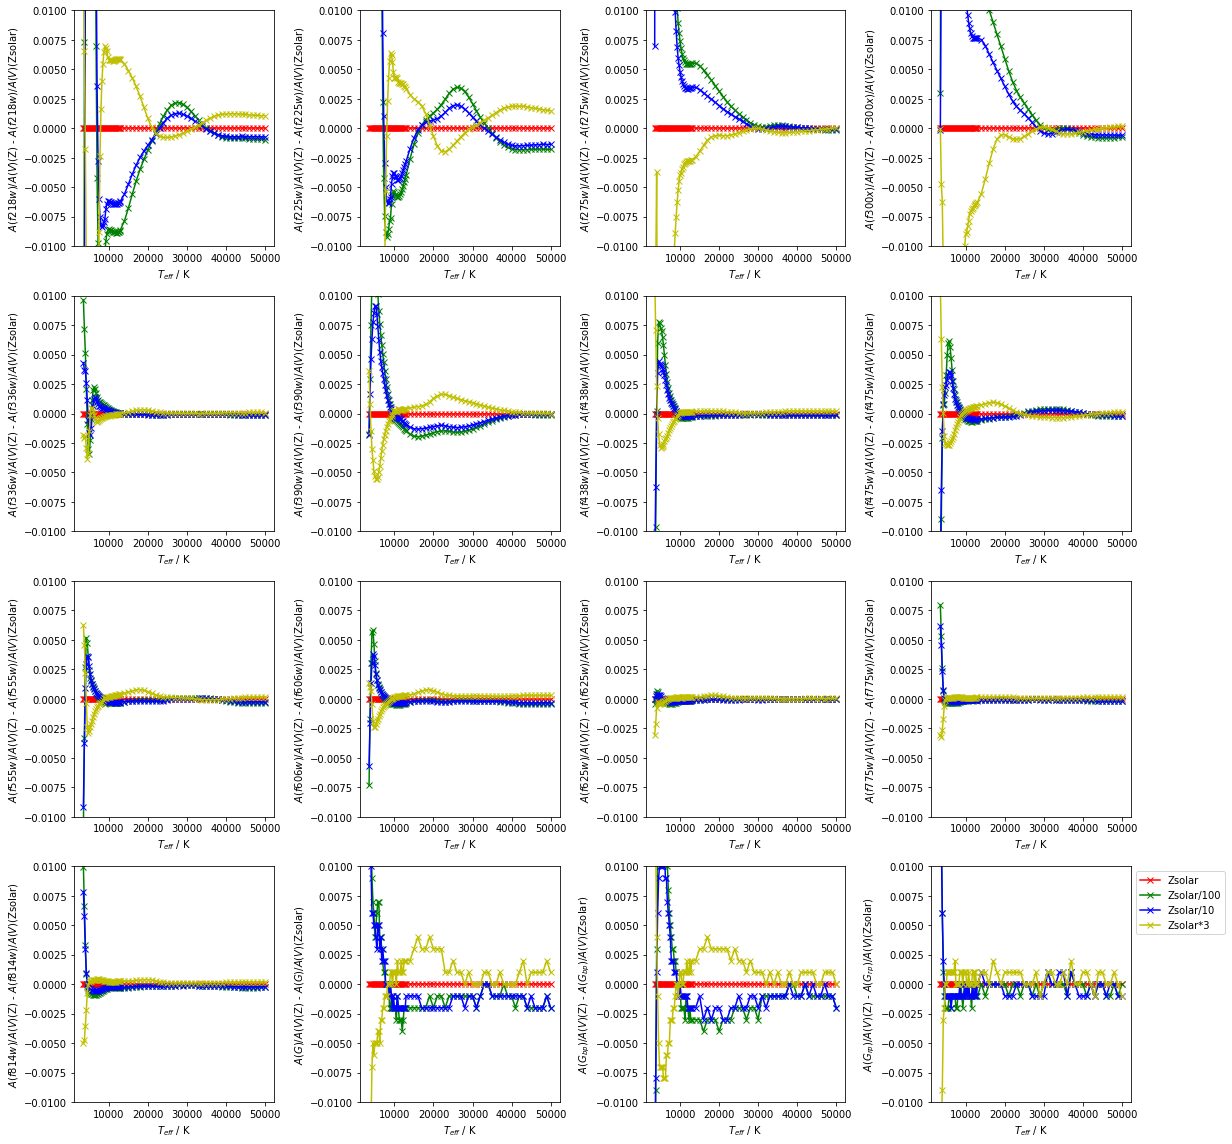

In [25]:
fig,zax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
zax = zax.ravel()

keyval = '5.0'
Teff_cut = 90000
#15000
#plt.set_cmap('gnuplot')
for i in range(2,18):
    #_4500K
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_zs[keyval])[:,i] - (comb_dict_zs[keyval])[:,i]),'r',marker='x',label='Zsolar')
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_z2[keyval])[:,i] - (comb_dict_zs[keyval])[:,i]),'g',marker='x',label='Zsolar/100')
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_z1[keyval])[:,i] - (comb_dict_zs[keyval])[:,i]),'b',marker='x',label='Zsolar/10')
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_zh[keyval])[:,i] - (comb_dict_zs[keyval])[:,i]),'y',marker='x',label='Zsolar*3')
    if (max((comb_dict_zs[keyval])[:,0]) > float(Teff_cut)):
        zax[i-2].set_xlim(min((comb_dict_zs[keyval])[:,0]),float(Teff_cut))
    #if (i==5):
    #    zax[i-2].set_ylim(1.96,2.00)
    zax[i-2].set_xlabel(var_names_comb[0])
    zax[i-2].set_ylabel(var_names_comb[i] + '(Z) - ' + var_names_comb[i] + '(Zsolar)')

    #zax[i-2].axhline(y=0.03,color='m',linestyle='--')
    #zax[i-2].axhline(y=-0.03,color='m',linestyle='--')
    zax[i-2].set_ylim(-0.01,0.01)
    #zax[i-2].axhline(y=0.02,color='m',linestyle='-.')
    #zax[i-2].axhline(y=-0.02,color='m',linestyle='-.')
    zax[i-2].ticklabel_format(useOffset=False)
    fig.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('Aall_vs_Teff_logg=' + keyval + '_all_Zs_diff_fulldata_Zsolar.pdf', bbox_inches='tight')

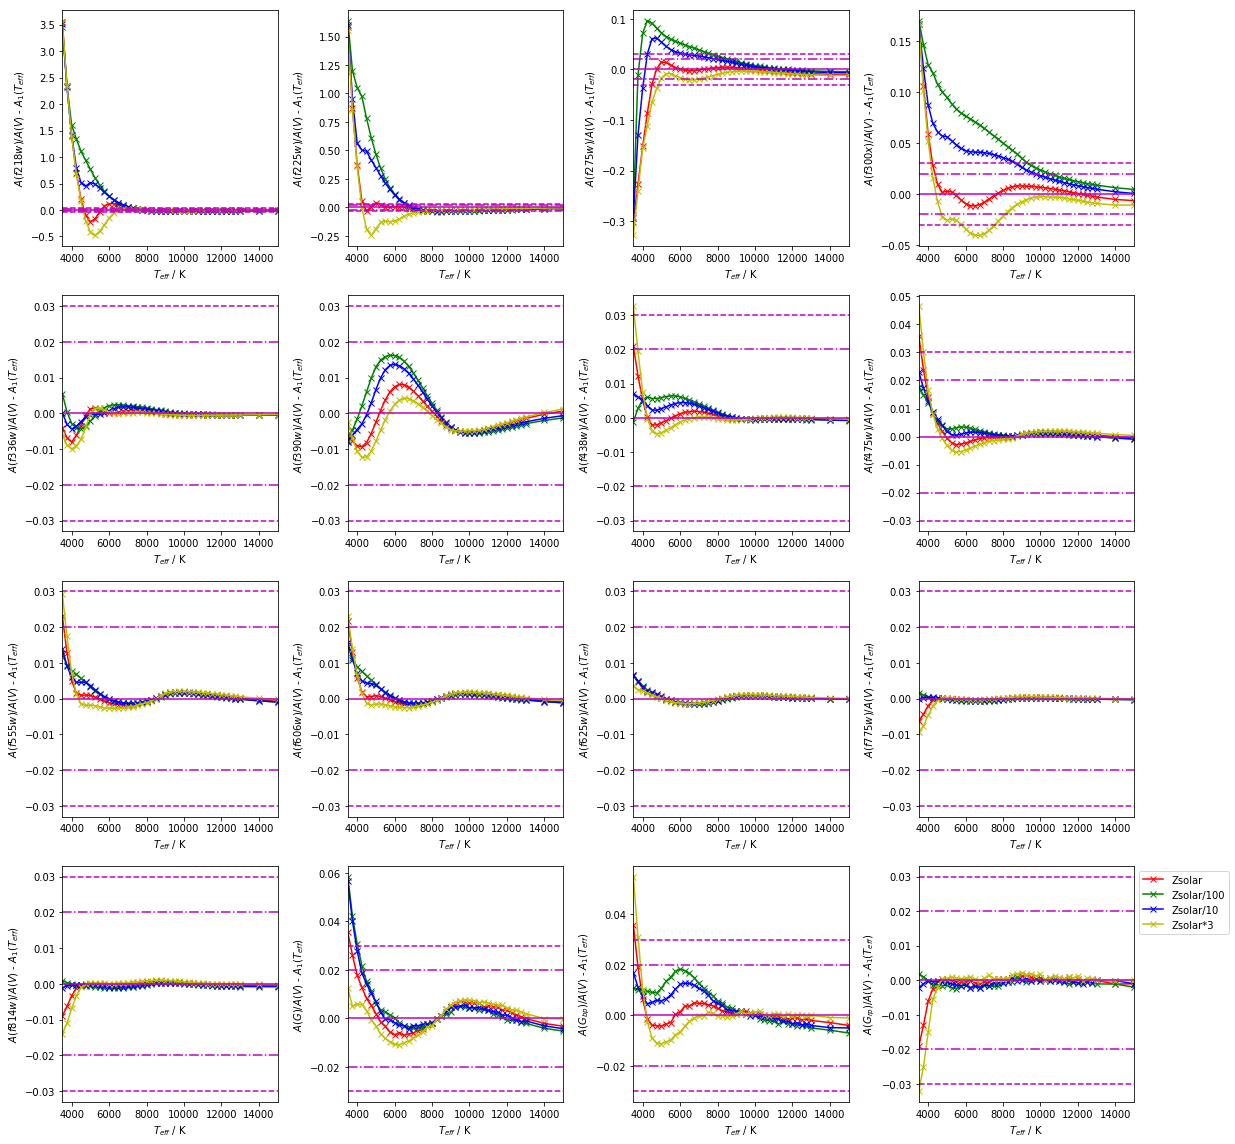

In [31]:
fig,zax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
zax = zax.ravel()

keyval = '5.0'
Teff_cut = 15000
#15000
#plt.set_cmap('gnuplot')
for i in range(2,18):
    #_4500K
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_zs[keyval])[:,i] - (R1_sim_points_dict_full[keyval])[:,i]),'r',marker='x',label='Zsolar')
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_z2[keyval])[:,i] - (R1_sim_points_dict_full[keyval])[:,i]),'g',marker='x',label='Zsolar/100')
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_z1[keyval])[:,i] - (R1_sim_points_dict_full[keyval])[:,i]),'b',marker='x',label='Zsolar/10')
    zax[i-2].plot((comb_dict_zs[keyval])[:,0],((comb_dict_zh[keyval])[:,i] - (R1_sim_points_dict_full[keyval])[:,i]),'y',marker='x',label='Zsolar*3')
    if (max((comb_dict_zs[keyval])[:,0]) > float(Teff_cut)):
        zax[i-2].set_xlim(min((comb_dict_zs[keyval])[:,0]),float(Teff_cut))
    #if (i==5):
    #    zax[i-2].set_ylim(1.96,2.00)
    zax[i-2].set_xlabel(var_names_comb[0])
    zax[i-2].set_ylabel(var_names_comb[i] + ' - $A_{1}(T_{eff})$')
    zax[i-2].axhline(y=0,color='m')
    zax[i-2].axhline(y=0.03,color='m',linestyle='--')
    zax[i-2].axhline(y=-0.03,color='m',linestyle='--')
    #zax[i-2].set_ylim(-0.02,0.02)
    zax[i-2].axhline(y=0.02,color='m',linestyle='-.')
    zax[i-2].axhline(y=-0.02,color='m',linestyle='-.')
    zax[i-2].ticklabel_format(useOffset=False)
    fig.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('Aall_vs_Teff_logg=' + keyval + '_all_Zs_diff_fulldata_R1_pred_15000K.pdf', bbox_inches='tight')

In [ ]:
# log(g) difference comparison

Teff_cut = 15000
lgc_keys_low = ['0.0','0.5','1.0','1.5','2.0']
lgc_keys_high = ['2.5','3.0','3.5','4.0','4.5']

ones_arr = np.copy((comb_dict_zs_4500K['5.0'])[:,0])
for j in range(len(ones_arr)):
    ones_arr[j] = 1.0
#print ones_arr

color_arr = ['k','r','b','g','y']#,'c'
print len(ones_arr)

fig,chax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
chax = chax.ravel()

for i in range(2,18):
    col_ind = 0
    #for key in sorted(comb_dict_zs_4500K.iterkeys()):lgc_keys_low lgc_keys_high
    for key in sorted(comb_dict_zs_4500K.iterkeys()):
        if (key == '5.0'):
            tint = 'c'
            mk_sty = '.'
        elif (col_ind < len(color_arr)):
            tint = color_arr[col_ind]
            if key in lgc_keys_high:
                mk_sty = '.'
            else:
                mk_sty = 'x'
        else:
            tint = color_arr[(col_ind - len(color_arr))]
            mk_sty = '.'
        #chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],(comb_dict_zs_4500K[key])[:,i],marker=mk_sty,label=('log(g)='+str(key)),color=tint)
        chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],((comb_dict_zh_4500K[key])[:,i] - (R1_sim_points_dict[key])[:,i]),marker=mk_sty,label=('log(g)='+str(key)),color=tint)#,linestyle='')   
        col_ind += 1
    #chax[i-2].plot((comb_dict_zs_4500K['5.0'])[:,0],ones_arr,'m')
    chax[i-2].axhline(y=0,color='m')
    chax[i-2].axhline(y=0.03,color='m',linestyle='--')
    chax[i-2].axhline(y=-0.03,color='m',linestyle='--')
    chax[i-2].axhline(y=0.02,color='m',linestyle='-.')
    chax[i-2].axhline(y=-0.02,color='m',linestyle='-.')
    #chax[i-2].axhline(y=max((comb_dict_zs_4500K['5.0'])[:,i]),color='m')
    chax[i-2].ticklabel_format(useOffset=False)
    chax[i-2].set_xlabel(var_names_comb[0])
    chax[i-2].set_ylabel(var_names_comb[i] + ' - $A_{1}(T_{eff})$')
    #if (max((comb_dict_z2_4500K[key])[:,0]) > float(Teff_cut)):
    #chax[i-2].set_ylim(-0.03,0.03)
    chax[i-2].set_xlim(4000,15000)

sup_title_str = 'Plots of extinction ratios for all log(g) values at Zsolar*(10^0.5), to compare'
fig.suptitle(sup_title_str,size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
plt.show()
fig.savefig(('Aall_R1_diff_comparison_logg_all_Zh_15000K.pdf'), bbox_inches='tight')# _high _low _all
# Aall_R1_diff_comparison_logg_all_Zsolar_15000K
# Aall_comparison_logg_all_Zsolar
# Aall_R1_diff_comparison_0.02_width_logg_all_Zsolar

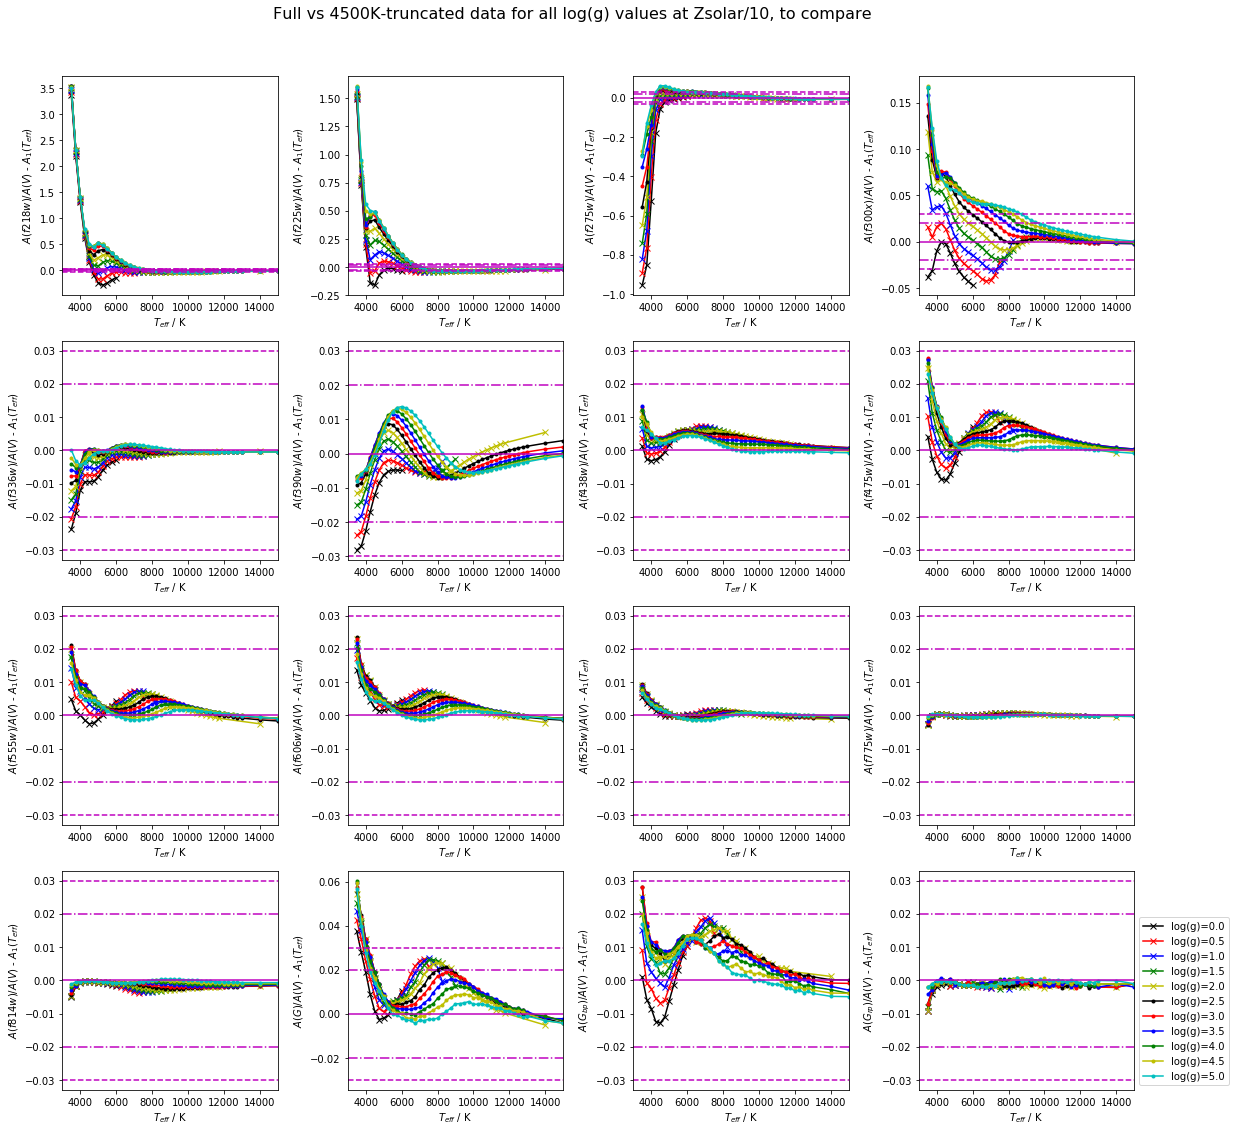

In [13]:
fig, truncax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
truncax = truncax.ravel()

Teff_cut = 15000
lgc_keys_low = ['0.0','0.5','1.0','1.5','2.0']
lgc_keys_high = ['2.5','3.0','3.5','4.0','4.5']
color_arr = ['k','r','b','g','y']#,'c'

for i in range(2,18):
    col_ind = 0
    #for key in sorted(comb_dict_zs_4500K.iterkeys()):lgc_keys_low lgc_keys_high
    for key in sorted(comb_dict_zs_4500K.iterkeys()):
        if (key == '5.0'):
            tint = 'c'
            mk_sty = '.'
        elif (col_ind < len(color_arr)):
            tint = color_arr[col_ind]
            if key in lgc_keys_high:
                mk_sty = '.'
            else:
                mk_sty = 'x'
        else:
            tint = color_arr[(col_ind - len(color_arr))]
            mk_sty = '.'
        #truncax[i-2].plot((comb_dict_zs_4500K[key])[:,0],(comb_dict_zs_4500K[key])[:,i],marker=mk_sty,label=('log(g)='+str(key)),color=tint)
        truncax[i-2].plot((comb_dict_z1[key])[:,0],((comb_dict_z1[key])[:,i] - (R1_sim_points_dict_full[key])[:,i]),marker=mk_sty,label=('log(g)='+str(key)),color=tint)#,linestyle='')   
        col_ind += 1
        
    truncax[i-2].axhline(y=0,color='m')
    truncax[i-2].axhline(y=0.03,color='m',linestyle='--')
    truncax[i-2].axhline(y=-0.03,color='m',linestyle='--')
    truncax[i-2].axhline(y=0.02,color='m',linestyle='-.')
    truncax[i-2].axhline(y=-0.02,color='m',linestyle='-.')
    #truncax[i-2].axhline(y=max((comb_dict_zs_4500K['5.0'])[:,i]),color='m')
    truncax[i-2].ticklabel_format(useOffset=False)
    truncax[i-2].set_xlabel(var_names_comb[0])
    truncax[i-2].set_ylabel(var_names_comb[i] + ' - $A_{1}(T_{eff})$')
    #truncax[i-2].set_ylim(-0.03,0.03)
    truncax[i-2].set_xlim(3000,15000)
    
sup_title_str = 'Full vs 4500K-truncated data for all log(g) values at Zsolar/10, to compare'
fig.suptitle(sup_title_str,size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
plt.show()
fig.savefig(('Aall_R1_fulldata_diff_comparison_logg_all_Z1_15000K.pdf'), bbox_inches='tight')# _high _low _all

truncations
original shape
(19L, 18L)
4.5
9000.0
5.0
9000.0
4.0
9000.0
3.5
9000.0
3.0
9000.0
2.0
9000.0
2.5
9000.0
comparison: 9000.0
72


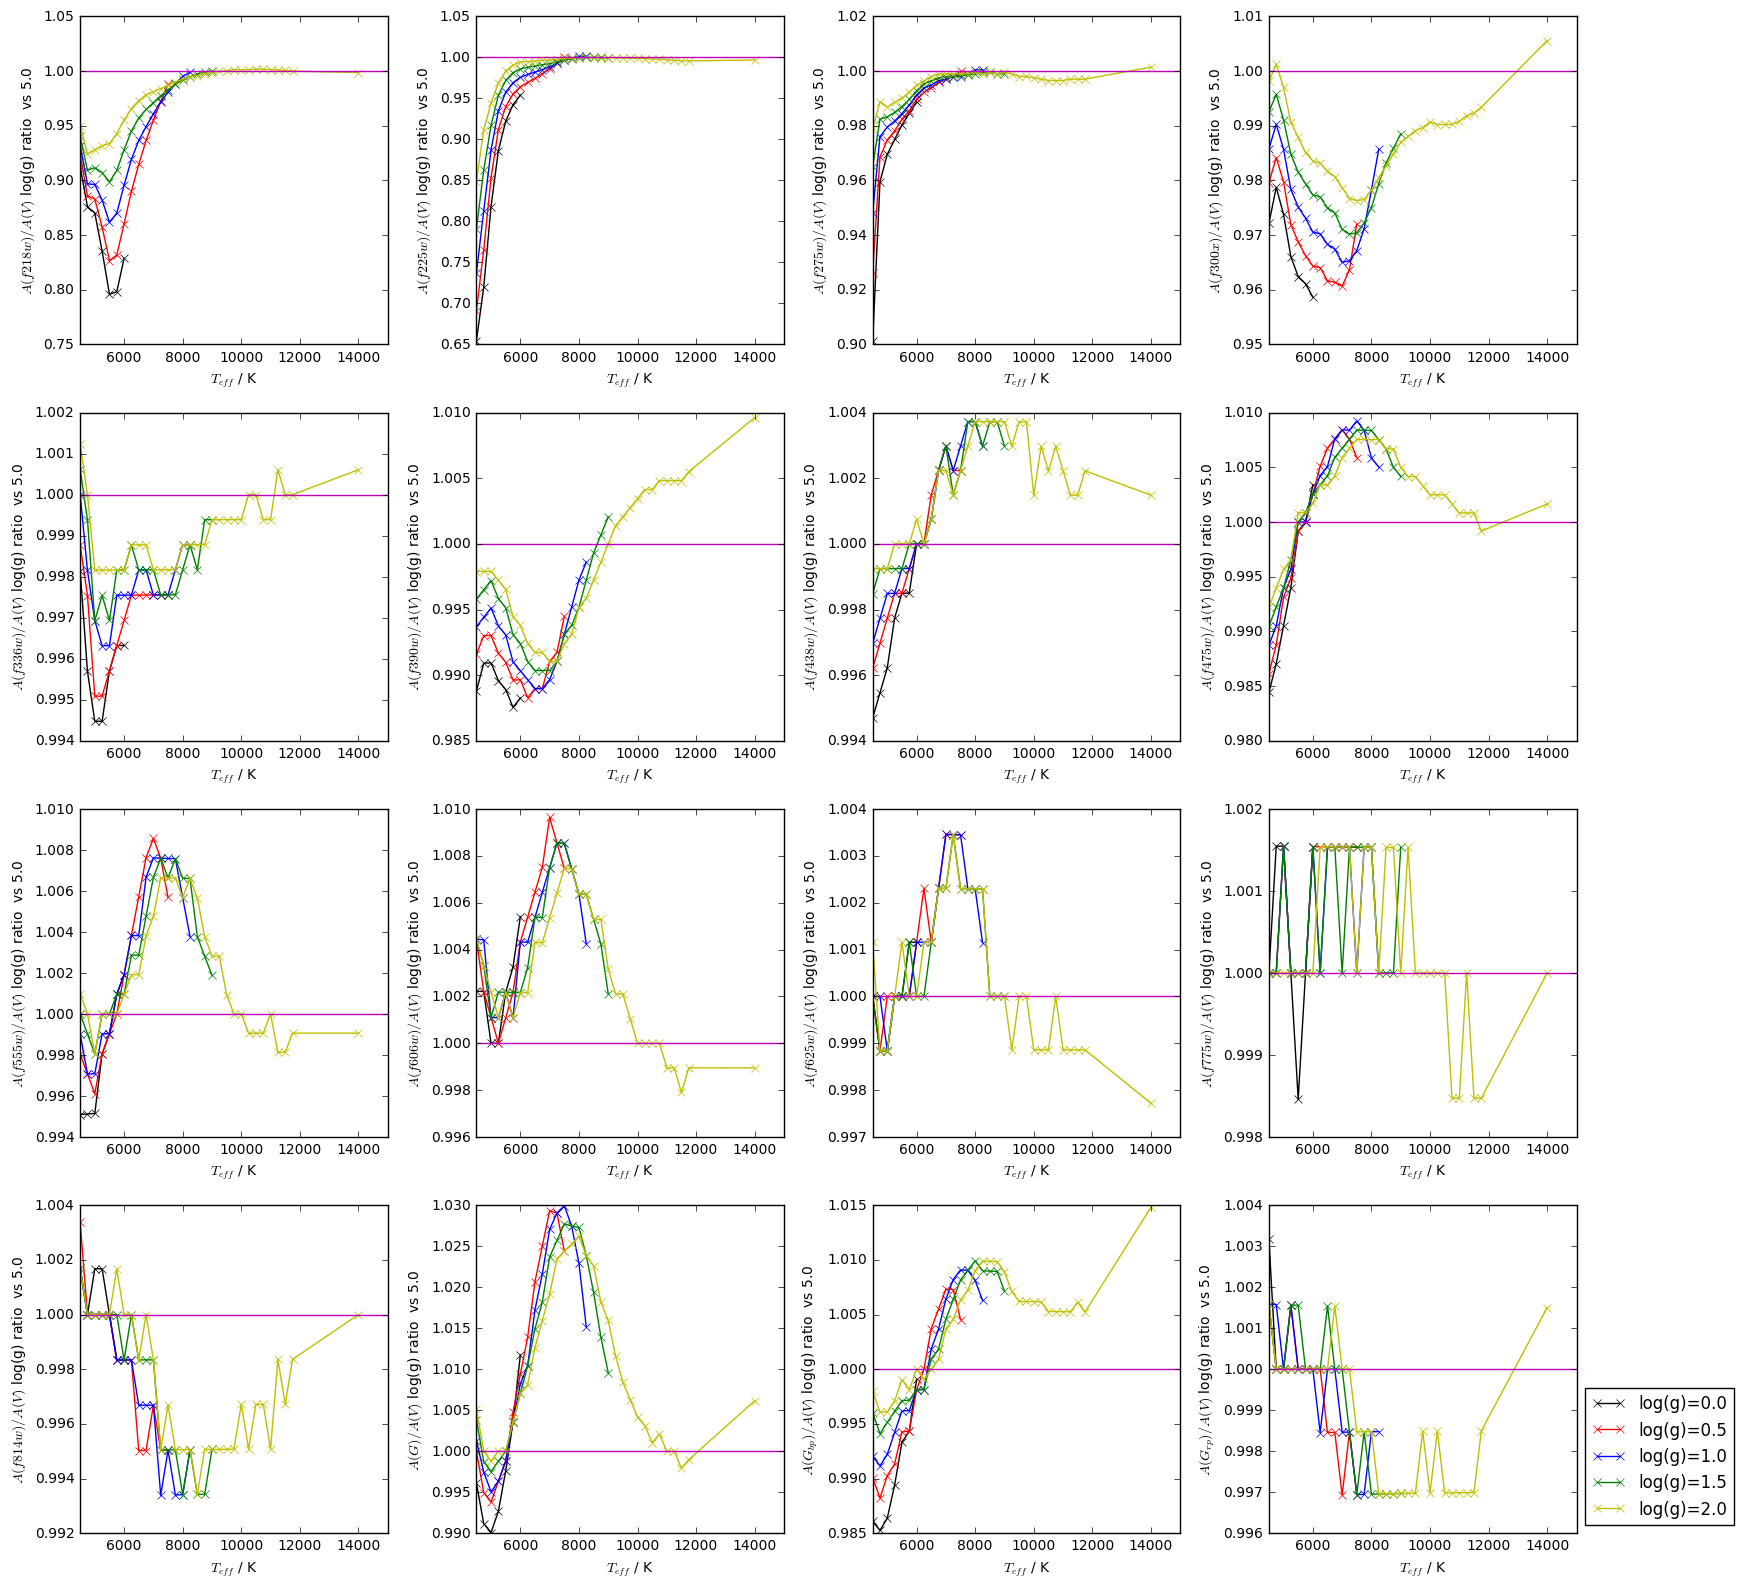

In [8]:
# log(g) ratio comparison
lgc_keys_low = ['0.0','0.5','1.0','1.5','2.0']
lgc_keys_high = ['2.5','3.0','3.5','4.0','4.5']

print 'truncations'
comb_dict_zs_4500K_trunc = trunc_data(comb_dict_zs_4500K,'1.5')
print 'original shape'
print comb_dict_zs_4500K['1.5'].shape

for key in comb_dict_zs_4500K_trunc:
    print key
    print max((comb_dict_zs_4500K_trunc[key])[:,0])
print 'comparison:',max((comb_dict_zs_4500K['1.5'])[:,0])

fig,chax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
chax = chax.ravel()
Teff_cut = 15000
ones_arr = np.copy((comb_dict_zs_4500K['5.0'])[:,0])
for j in range(len(ones_arr)):
    ones_arr[j] = 1.0
#print ones_arr

color_arr = ['k','r','b','g','y']#,'c'
print len(ones_arr)

for i in range(2,18):
    col_ind = 0
    #for key in sorted(comb_dict_zs_4500K.iterkeys()):lgc_keys_low lgc_keys_high
    for key in lgc_keys_low:
        if (key != '5.0'):
            if (col_ind < len(color_arr)):
                tint = color_arr[col_ind]
                if key in lgc_keys_high:
                    mk_sty = '.'
                else:
                    mk_sty = 'x'
            else:
                tint = color_arr[(col_ind - len(color_arr))]
                mk_sty = '.'
            comb_dict_zs_4500K_trunc = trunc_data(comb_dict_zs_4500K,key)
            #  - (R1_sim_points_dict[key])[:,i] /(comb_dict_zs_4500K_trunc['5.0'])[:,i]
            chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],((comb_dict_zs_4500K[key])[:,i]  - (R1_sim_points_dict[key])[:,i]),marker=mk_sty,label=('log(g)='+str(key)),color=tint)#,linestyle='')   
            col_ind += 1
    chax[i-2].plot((comb_dict_zs_4500K['5.0'])[:,0],ones_arr,'m')
    chax[i-2].ticklabel_format(useOffset=False)
    chax[i-2].set_xlabel(var_names_comb[0])
    chax[i-2].set_ylabel(var_names_comb[i] + ' log(g) ratio  vs 5.0')
    #if (max((comb_dict_z2_4500K[key])[:,0]) > float(Teff_cut)):
    chax[i-2].set_xlim(min((comb_dict_z2_4500K['0.0'])[:,0]),float(Teff_cut))
    fig.tight_layout()
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
plt.show()
fig.savefig(('Aall_ratio_low_logg_div_5.0_effect.pdf'), bbox_inches='tight')# _high _low
#'_zoom_'+ str(Teff_cut) +


72


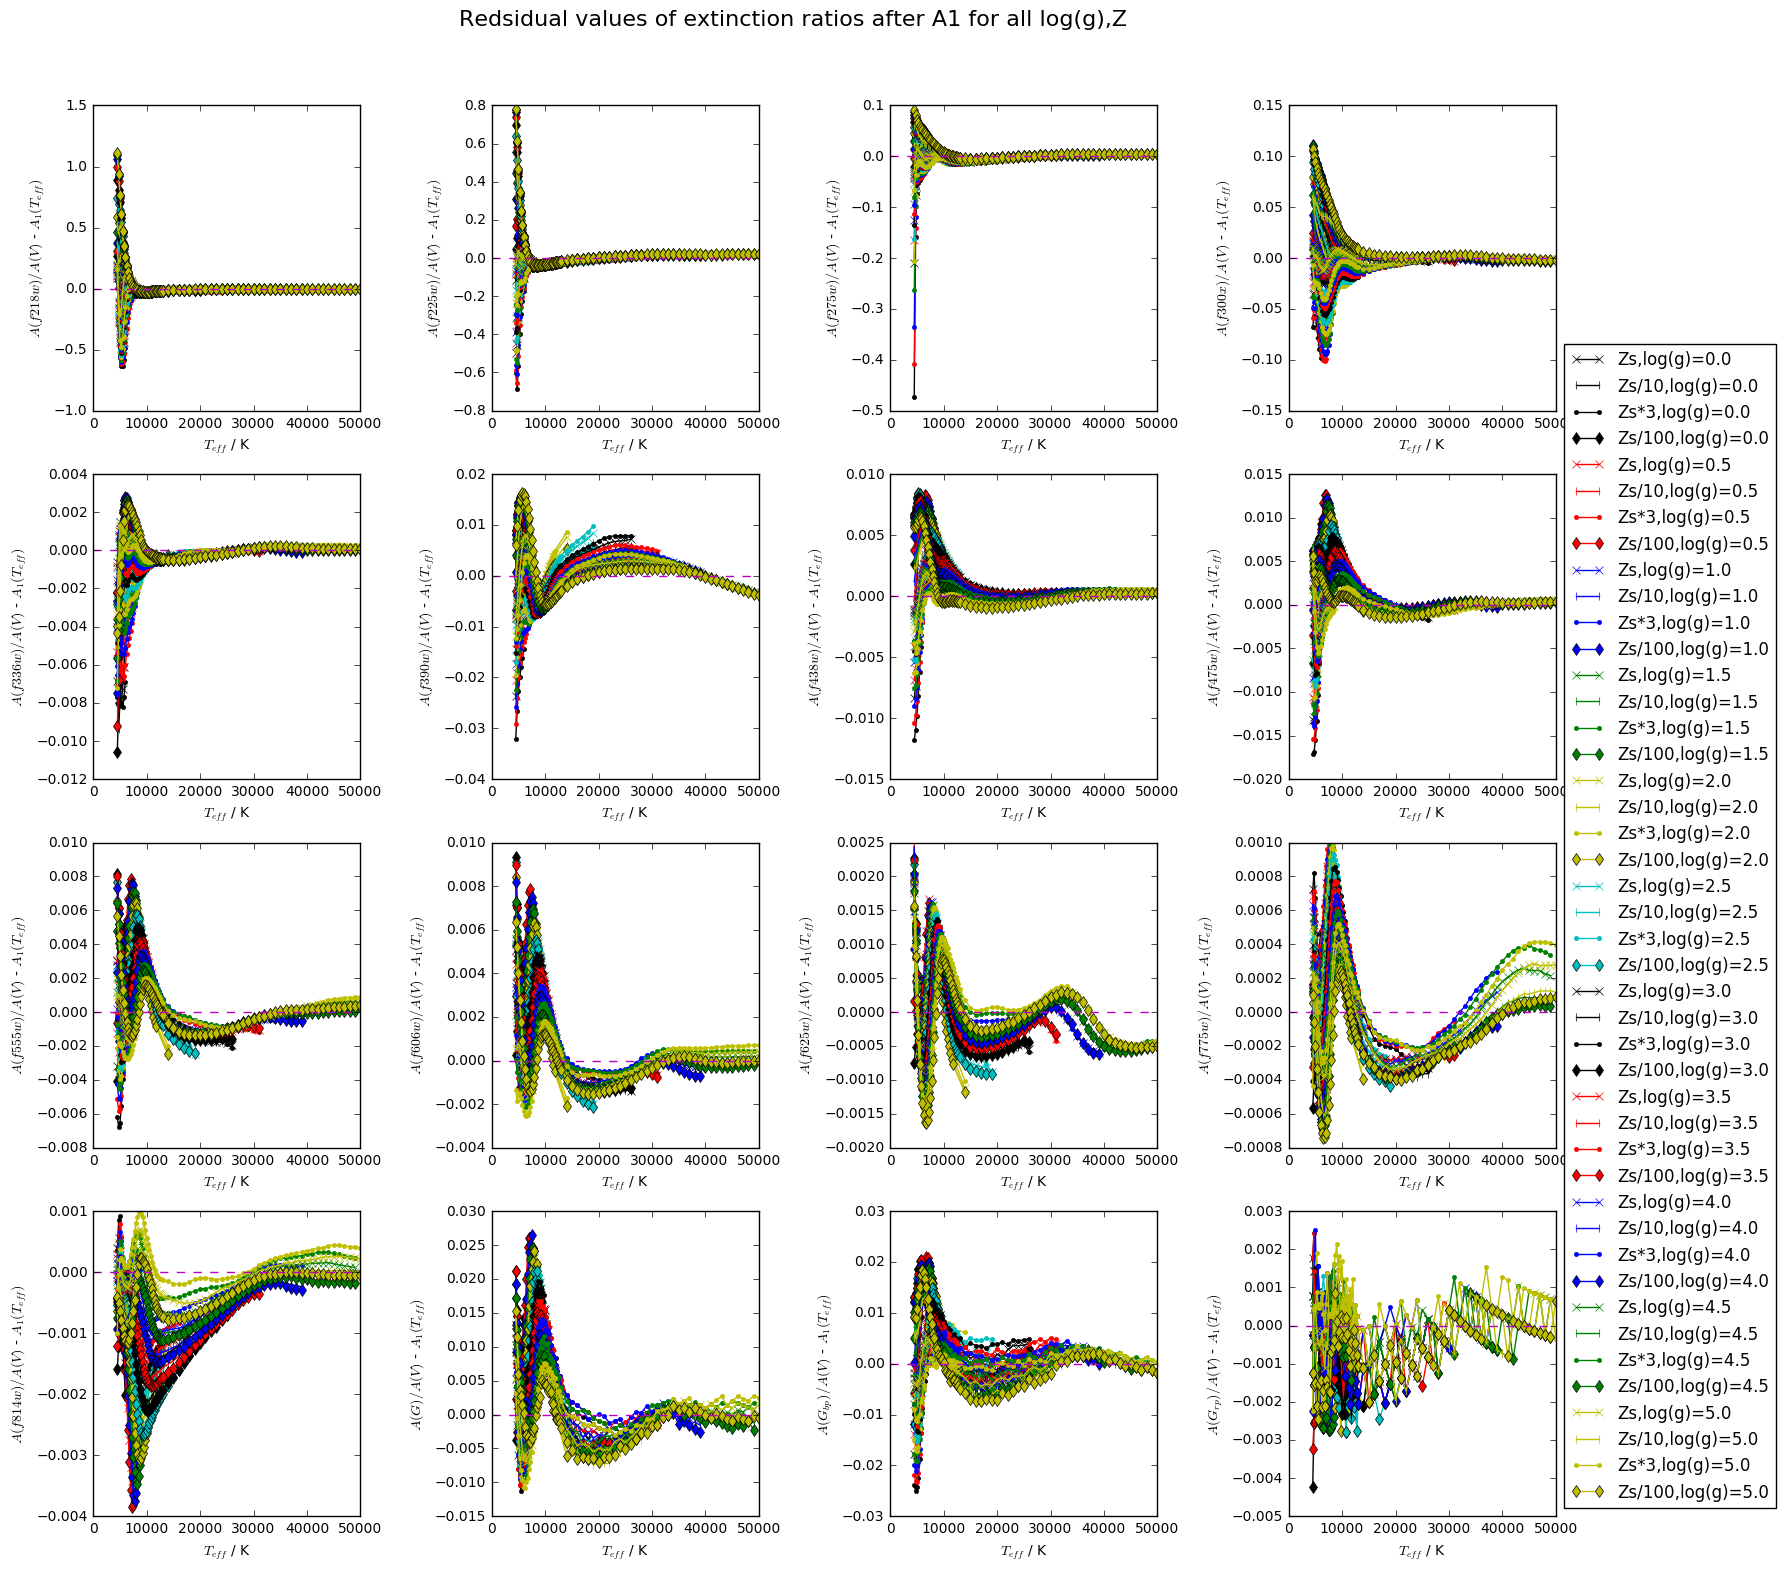

plot done!


In [74]:
# Z-value comparison
fig,chax = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
chax = chax.ravel()

zc_keys_low = ['0.0','0.5','1.0','1.5','2.0']
zc_keys_high = ['2.5','3.0','3.5','4.0','4.5','5.0']

Teff_cut = 15000
ones_arr = np.copy((comb_dict_zs_4500K['5.0'])[:,0])

for j in range(len(ones_arr)):
    ones_arr[j] = 1.0
#print ones_arr
print len(ones_arr)

color_arr = ['c','k','r','b','g','y']

for i in range(2,18):
    col_ind = 0
    #for key in sorted(comb_dict_zs_4500K.iterkeys()):zc_keys_low zc_keys_high
    for key in sorted(comb_dict_zs_4500K.iterkeys()):
        if (key in zc_keys_low):
            tint = color_arr[col_ind + 1]
        elif (key in zc_keys_high):
            if ((col_ind+1) < len(color_arr)):
                tint = color_arr[col_ind]
            elif (col_ind < len(color_arr) and key == '5.0'):
                tint = color_arr[col_ind]
            else:
                tint = color_arr[((col_ind + 1) - len(color_arr))]
            #+'|'+str(col_ind)
        # - (R1_sim_points_dict[key])[:,i] /(comb_dict_z2_4500K[key])[:,i]
        chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],((comb_dict_zs_4500K[key])[:,i] - (R1_sim_points_dict[key])[:,i]),marker='x',label=('Zs,log(g)='+key),color=tint)#,linestyle='')     
        chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],((comb_dict_z1_4500K[key])[:,i] - (R1_sim_points_dict[key])[:,i]),marker='|',label=('Zs/10,log(g)='+key),color=tint)#,linestyle='')
        chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],((comb_dict_zh_4500K[key])[:,i] - (R1_sim_points_dict[key])[:,i]),marker='.',label=('Zs*3,log(g)='+key),color=tint)#,linestyle='')
        chax[i-2].plot((comb_dict_zs_4500K[key])[:,0],((comb_dict_z2_4500K[key])[:,i] - (R1_sim_points_dict[key])[:,i]),marker='d',label=('Zs/100,log(g)='+key),color=tint)#,linestyle='')
        col_ind += 1
    chax[i-2].axhline(y=0.0,color='m',linestyle='--')
    chax[i-2].ticklabel_format(useOffset=False)
    chax[i-2].set_xlabel(var_names_comb[0])
    chax[i-2].set_ylabel(var_names_comb[i] + ' - $A_{1}(T_{eff})$')# + ' Z-ratio'
    #if (max((comb_dict_z2_4500K[key])[:,0]) > float(Teff_cut)):
    #chax[i-2].set_xlim(min((comb_dict_z2_4500K['0.0'])[:,0]),float(Teff_cut))

sup_title_str = 'Redsidual values of extinction ratios after A1 for all log(g),Z'
fig.suptitle(sup_title_str,size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
#fig.colorbar()

plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
plt.show()
fig.savefig(('Aall_ratio_Zs_minus_R1_effect_all_logg.pdf'), bbox_inches='tight')
# div_Z2
#'_zoom_'+ str(Teff_cut) +

print 'plot done!'

BaSTI isochrone dataset:  (2100L, 21L)
2100 2100
494 2100
494 2100


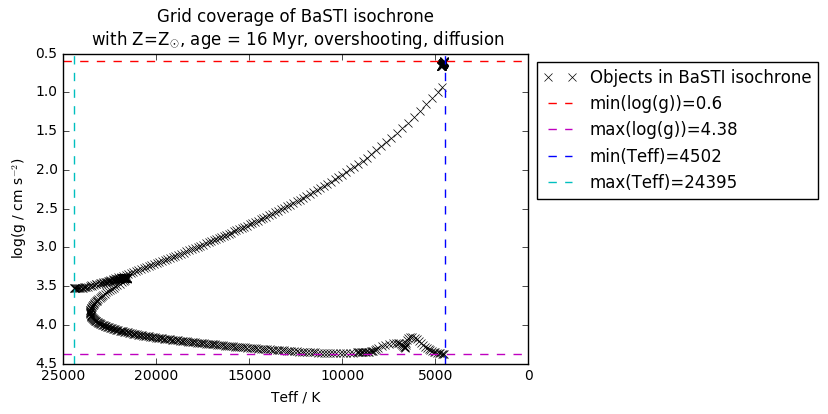

log(g) range: 0.6 to 4.38
Teff range: 4502 to 24395
<type 'numpy.float64'> <type 'int'>


In [13]:
# isochrone data cell
# REMEMBER!: cgs units!!!
# wfc3_16_23Myr_10Gyr_complex_solar # dr2_16Myr_10Gyr_complex_solar
# _basic z01721y269p00o0d0e0 # _complex z01721y269p00o1d1e1
# .isc_wfc3 # .isc_gaia2

basti_age_Myr = 16
with open(('wfc3_16_23Myr_10Gyr_complex_solar/'+str(basti_age_Myr)+'z01721y269p00o1d1e1.isc_wfc3'),'r') as isofile_c16:
    isodata_c16 = data_read_basti_isochrone(isofile_c16)

# initial mass
Mini_c16 = isodata_c16[:,0]
# final (i.e. at this age) time
Mfin_c16 = isodata_c16[:,1]
# log(L/Lsun)
logLstar_c16 = isodata_c16[:,2]
# log(Teff/K)
logTeff_c16 = isodata_c16[:,3]

# g = GMfin/R^2
# R^2 = L/((Teff^4)*4*pi*sigma_SB)

# set universal constants
G = 6.67428e-8
sigma_SB = 5.6704e-5
Lsun = 3.828e+33
Msun = 1.98847e+33

# Note: all variable parameters below are array objects!
Mini_gram_c16 = Mini_c16*Msun
Mfin_gram_c16 = Mfin_c16*Msun
Lstar_c16 = Lsun * (10**(logLstar_c16))
Teff_c16 = 10**(logTeff_c16)
Rstar_sq_c16 = Lstar_c16/(4*(math.pi)*sigma_SB*(Teff_c16**4))
# get g-value
g_c16 = (G*Mfin_gram_c16)/Rstar_sq_c16
logg_c16 = np.log10(g_c16)
print len(logg_c16),len(Teff_c16)

# plot feasibility grid
Teff_cut = 4500.0
temp_tlist = []
for point in range(len(Teff_c16)):
    points_list = []
    if (Teff_c16[point] >= Teff_cut):
        points_list.append(Teff_c16[point])
        points_list.append(logg_c16[point])
        temp_tlist.append(points_list)
    
trunc_isoc_arr = np.array(temp_tlist)
Teff_c16_trunc = trunc_isoc_arr[:,0]
logg_c16_trunc = trunc_isoc_arr[:,1]
print len(Teff_c16_trunc),len(Teff_c16)
print len(logg_c16_trunc),len(logg_c16)

fig,ax = plt.subplots()
ax.plot(Teff_c16_trunc,logg_c16_trunc,color='k',marker='x',linestyle='', label='Objects in BaSTI isochrone')
# set boundaries of Teff, log(g)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
min_g = np.around(min(logg_c16_trunc),decimals=2)
max_g = np.around(max(logg_c16_trunc),decimals=2)
#min_Teff = np.around(min(Teff_c16))
min_Teff = int(min(Teff_c16_trunc))
#max_Teff = np.around(max(Teff_c16))
max_Teff = int(max(Teff_c16_trunc))
#print type(min(Teff_c16)),type(min_Teff)

ax.axhline(y=min_g, color='r',linestyle='--', label=('min(log(g))='+str(min_g)))
ax.axhline(y=max_g, color='m',linestyle='--', label=('max(log(g))='+str(max_g)))
ax.axvline(x=min_Teff, color='b',linestyle='--', label=('min(Teff)='+str(min_Teff)))
ax.axvline(x=max_Teff, color='c',linestyle='--', label=('max(Teff)='+str(max_Teff)))

ax.set_xlabel('Teff / K')
ax.set_ylabel('log(g / cm s$^{-2}$)')
ax.set_title('Grid coverage of BaSTI isochrone\n with Z=Z$_{\odot}$, age = '+str(basti_age_Myr)+' Myr, overshooting, diffusion')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('wfc3_16_23Myr_10Gyr_complex_solar/ATLAS9_grid_BaSTI_coverage_c'+str(basti_age_Myr)+'.pdf',bbox_inches='tight')

print 'log(g) range: ' + str(min_g) + ' to ' + str(max_g)
print 'Teff range: ' + str(min_Teff) + ' to ' + str(max_Teff)
print type(min(Teff_c16)),type(min_Teff)


In [48]:
"""
ylist = []
for g in logg_vals_arr:
    y = Teff_logg_product_func(Teff_vals_arr,(5.0-g),0.000001,-0.01,0.0)
    ylist.append(y)

fig,ax = plt.subplots()
for g in range(len(logg_vals_arr)):
    yarr = np.array(ylist[g])
    ax.plot(Teff_vals_arr,yarr,label=('log(g)=' + str(logg_vals_arr[g])))
#ax.set_ylim(0.3,4.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()"""

"\nylist = []\nfor g in logg_vals_arr:\n    y = Teff_logg_product_func(Teff_vals_arr,(5.0-g),0.000001,-0.01,0.0)\n    ylist.append(y)\n\nfig,ax = plt.subplots()\nfor g in range(len(logg_vals_arr)):\n    yarr = np.array(ylist[g])\n    ax.plot(Teff_vals_arr,yarr,label=('log(g)=' + str(logg_vals_arr[g])))\n#ax.set_ylim(0.3,4.5)\nplt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))\nplt.show()"

In [11]:
print 'logg results storage size:'
print len(logg_coeffs_stored),len(logg_coeffs_stored[0])
for i in logg_coeffs_stored:
    print i

logg results storage size:
16 3
[-0.00074592  0.02656597 -0.11425175]
[-0.01537529  0.17502191 -0.48683916]
[-0.01082517  0.08743497 -0.1755035 ]
[-0.00420047  0.03000233 -0.04652448]
[-0.00070862  0.00423403 -0.00347552]
[-0.00103496  0.00841119 -0.01606294]
[-0.00054545  0.00412727 -0.00709091]
[-0.00035897  0.00548578 -0.0183007 ]
[-0.00063869  0.00404802 -0.00453147]
[-0.0004662   0.00178555  0.00252448]
[ -4.19580420e-05   1.91608392e-04  -2.09790210e-05]
[ 0.  0.  0.]
[ -6.99300699e-05   2.22377622e-04   1.14685315e-03]
[-0.00098368  0.00555478 -0.00300699]
[-0.0011049   0.00852448 -0.01437063]
[  3.26340326e-05  -4.35897436e-04   1.62237762e-03]


In [53]:
"""
# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')


if (col_x == 1):
                    f.write('Filter ratio (y-axis): ' + var_names[i] + '\n')
                    f.write('Fixed parameter: log(g) = ' + i + '\n')
                    f.write('Quadratic fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n')
                    f.close()
                elif (col_x == 2):"""
"""
exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))
pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))
spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))
#log_fit_A_logg5, covarr_A_logg5_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],exp_func((A_X_zs_gfix['5.0'])[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly((A_X_zs_gfix['5.0'])[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly_plus_exp_func((A_X_zs_gfix['5.0'])[:,0],*spp_exp_fit_A_logg5),'r',label=fit_types[2])

#ax.set_xlim(3000,10000)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf', bbox_inches='tight')



def low_logg_law_trunc(whole_dict,err_lim):
    # use log(g)-keyed dictionaries to save memory
    # get log(g) = 5 dictionary (the one the model is fitted to) as the reference data
    a = whole_dict['5.0']
    for key in sorted(whole_dict.iterkeys()):
        k = ''
        if (key != '5.0'):
            b = whole_dict[key]
                # find the range for which data spread greater than 0.01   
            for i in range(len(b[:,0])): # row number iteration
                x = 0
                for j in range(2,len(b[0,:])): # column number iteration
                    if (x != 0):
                        k = '\t'
                    # data spread condition
                    dif = a[i,j]-b[i,j]
                    if (abs(dif) >= err_lim):
                        print k + 'Teff=',b[i,0],', log(g)=',b[i,1],', column ',(j+1),', difference=',dif
                        k = ''
                        x += 1

#print ' \t Full-Data Dictionary'
#low_logg_law_trunc(comb_dict_zs,0.01)
#print '\n \t Teff >= 4500K Data Dictionary'
#low_logg_law_trunc(comb_dict_zs_4500K,0.01)
"""

"\nexp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))\npow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))\nspp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))\n#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))\n\nfig, ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel(var_names[4])\n\nax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')\nax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limi